In [1]:
from IPython.display import display
from IPython.display import clear_output
from tqdm import tqdm
import ipywidgets as widgets
from jupyter_bbox_widget import BBoxWidget
from ipywidgets import Layout, interact
from dotenv import load_dotenv

import numpy as np
import xarray as xr
from branca.colormap import linear
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm # To specify colormaps
import pandas as pd
# import matplotlib.pyplot as plt

import geopandas as gpd
import pycountry
from shapely import wkt, Polygon
import folium
import lonboard
import pydeck as pdk
# import openeo 
# import pystac_client
# import easystac
# import cubo

import duckdb
import datahugger
import sciencebasepy
from seedir import seedir

# python libraries
import os
import json
import requests
import urllib.parse
from pathlib import Path
import subprocess
import tempfile
import shutil
import pprint as pp
import time
import json
import re
from zipfile import ZipFile
import random
from typing import Optional, List, Dict, Tuple, Any

# Import refactored utility functions
from utils.fetch_and_preprocess import (
    fetch_dataset_files, 
    filter_gdf_duplicates, 
    process_vector_geoms, 
    geom_db_consolidate_dataset,
    ddb_filter_duplicates
)
from utils.visualizations import (
    format_dataset_info,
    create_folium_cluster_map,
    create_folium_choropleth,
    create_folium_heatmap,
    create_pydeck_scatterplot,
    create_pydeck_polygons,
    create_pydeck_heatmap
)

from utils.st_context_processing import (
    add_h3_index_to_pv_labels,
    ddb_alter_table_add_h3,
    ddb_save_div_matches,
    ddb_save_subtype_geoms,
    get_duckdb_connection,
    group_pv_by_h3_cells,
    spatial_join_stac_items_with_h3,
    create_h3_stac_fetch_plan,
    fetch_overture_maps_theme,
    spatial_join_pv_overture_duckdb
)

# Fetch Open, Published Datasets of PV Solar Panel locations across the world

Many of these datasets are located in [Zenodo](https://zenodo.org/), a general-purpose open-access repository developed under the European OpenAIRE program and operated by CERN. Others are hosted in figshare, a web-based platform for sharing research data and other types of content. The rest are hosted in GitHub repositories or other open-access data platforms.

The datasets are available in a variety of formats, including CSV, GeoJSON, GeoPackage, ESRI shapefiles, raw raster masks, and *[GeoParquet](#Intro-to-GeoParquet)*. We'll be using open-source Python libraries to download and process them into properly georeferenced geoparquet files that we'll manage using [dbt-core+duckdb](https://motherduck.com/blog/motherduck-duckdb-dbt/) (see these short videos on [this stack](https://www.youtube.com/watch?v=asxGh2TrNyI) and [MotherDuck](https://www.youtube.com/watch?v=OuCY7_DzCTA) to scale compute and storage in the cloud *with the same tools and codebase*.


<!-- prev note for Georectified USA (Note: these correspond to PV _facilities_ rather than individual panel arrays or objects and need filtering of duplicates with other datasets and further processing to extract the PV arrays in the facility) -->

Here we list the dataset titles of publications alongside their first author, DOI links, and their number of labels:
- **"Distributed solar photovoltaic array location and extent dataset for remote sensing object identification"** - K. Bradbury, 2016 | [paper DOI](https://doi.org/10.1038/sdata.2016.106) | [dataset DOI](https://doi.org/10.6084/m9.figshare.3385780.v4) | polygon annotations for 19,433 PV modules in 4 cities in California, USA
- "A solar panel dataset of very high resolution satellite imagery to support the Sustainable Development Goals" - C. Clark et al, 2023 | [paper DOI](https://doi.org/10.1038/s41597-023-02539-8) | [dataset DOI](https://doi.org/10.6084/m9.figshare.22081091.v3) | 2,542 object labels (per spatial resolution)
- **"A harmonised, high-coverage, open dataset of solar photovoltaic installations in the UK" - D. Stowell et al, 2020** | [paper DOI](https://doi.org/10.1038/s41597-020-00739-0) | [dataset DOI](https://zenodo.org/records/4059881) | 265,418 data points (over 255,000 are stand-alone installations, 1067 solar farms, and rest are subcomponents within solar farms)
- "Georectified polygon database of ground-mounted large-scale solar photovoltaic sites in the United States" - K. Sydny, 2023 | [paper DOI](https://doi.org/10.1038/s41597-023-02644-8) | [dataset DOI](https://www.sciencebase.gov/catalog/item/6671c479d34e84915adb7536) | 4186 data points 
- "Vectorized solar photovoltaic installation dataset across China in 2015 and 2020" - J. Liu et al, 2024 | [paper DOI](https://doi.org/10.1038/s41597-024-04356-z) | [dataset link](https://github.com/qingfengxitu/ChinaPV) | 3,356 PV labels (inspect quality!)
- "Multi-resolution dataset for photovoltaic panel segmentation from satellite and aerial imagery" - H. Jiang, 2021 | [paper DOI](https://doi.org/10.5194/essd-13-5389-2021) | [dataset DOI](https://doi.org/10.5281/zenodo.5171712) | 3,716 samples of PV data points
- "A crowdsourced dataset of aerial images with annotated solar photovoltaic arrays and installation metadata" - G. Kasmi, 2023 | [paper DOI](https://doi.org/10.1038/s41597-023-01951-4) | [dataset DOI](https://doi.org/10.5281/zenodo.6865878) | > 28K points of PV installations; 13K+ segmentation masks for PV arrays; metadata for 8K+ installations
- **"An Artificial Intelligence Dataset for Solar Energy Locations in India"** - A. Ortiz, 2022 | [paper DOI](https://doi.org/10.1038/s41597-022-01499-9) | [dataset link 1](https://researchlabwuopendata.blob.core.windows.net/solar-farms/solar_farms_india_2021.geojson) or [dataset link 2](https://raw.githubusercontent.com/microsoft/solar-farms-mapping/refs/heads/main/data/solar_farms_india_2021_merged_simplified.geojson) | 117 geo-referenced points of solar installations across India
- "GloSoFarID: Global multispectral dataset for Solar Farm IDentification in satellite imagery" - Z. Yang, 2024** | [paper DOI](https://doi.org/10.48550/arXiv.2404.05180) | [dataset DOI](https://github.com/yzyly1992/GloSoFarID/tree/main/data_coordinates) | 6,793 PV samples across 3 years (double counting of samples)
- **"A global inventory of photovoltaic solar energy generating units" - L. Kruitwagen et al, 2021** | [paper DOI](https://doi.org/10.1038/s41586-021-03957-7) | [dataset DOI](https://doi.org/10.5281/zenodo.5005867) | 50,426 for training, cross-validation, and testing; 68,661 predicted polygon labels 
- **"Harmonised global datasets of wind and solar farm locations and power" - S. Dunnett et al, 2020** | [paper DOI](https://doi.org/10.1038/s41597-020-0469-8) | [dataset DOI](https://doi.org/10.6084/m9.figshare.11310269.v6) | 35272 PV installations

# Dataset Metadata and Preparation

We will use datahugger, sciencebasepy, and osf-client to manage official dataset records published in open access scientific data repositories.
We also implement some ad-hoc functions to download some data assets hosted in GitHub repositories. 
We will also use geopandas, rasterio, and pyproj to process the datasets into georeferenced geoparquet files. 

In [2]:
# load environment variables
load_dotenv()
DATASET_DIR = Path(os.getenv('DATA_PATH'))
# read dataset metadata from json file
with open('dataset_metadata.json', 'r') as f:
    dataset_metadata = json.load(f)

dataset_choices = [
    'global_harmonized_large_solar_farms_2020',
    # 'global_pv_inventory_sent2_2024',
    'global_pv_inventory_sent2_spot_2021',
    # 'fra_west_eur_pv_installations_2023',
    'ind_pv_solar_farms_2022',
    'usa_cali_usgs_pv_2016',
    # 'chn_med_res_pv_2024',
    # 'usa_eia_large_scale_pv_2023',
    'uk_crowdsourced_pv_2020',
    # 'deu_maxar_vhr_2023'   
]

In [3]:
# Initialize a list to store selected datasets
# mostly gen by github copilot with Claude 3.7 model
selected_datasets = dataset_choices.copy()

# Create an accordion to display selected datasets with centered layout
dataset_accordion = widgets.Accordion(
    children=[widgets.HTML(format_dataset_info(ds)) for ds in selected_datasets],
    layout=Layout(width='50%', margin='0 auto')
)
for i, ds in enumerate(selected_datasets):
    dataset_accordion.set_title(i, ds)

# Define a function to add or remove datasets
def manage_datasets(action, dataset=None):
    global selected_datasets, dataset_accordion
    
    if action == 'add' and dataset and dataset not in selected_datasets:
        selected_datasets.append(dataset)
    elif action == 'remove' and dataset and dataset in selected_datasets:
        selected_datasets.remove(dataset)
    
    # Update the accordion with current selections
    dataset_accordion.children = [widgets.HTML(format_dataset_info(ds)) for ds in selected_datasets]
    for i, ds in enumerate(selected_datasets):
        dataset_accordion.set_title(i, ds)
    
    f"Currently selected datasets: {len(selected_datasets)}"

# Create dropdown for available datasets
dataset_dropdown = widgets.Dropdown(
    options=list(dataset_metadata.keys()),
    description='Dataset:',
    disabled=False,
    layout=Layout(width='70%', margin='20 20 auto 20 20')
)

# Create buttons for actions
add_button = widgets.Button(description="Add Dataset", button_style='success')
remove_button = widgets.Button(description="Remove Dataset", button_style='danger')

# Define button click handlers
def on_add_clicked(b):
    manage_datasets('add', dataset_dropdown.value)

def on_remove_clicked(b):
    manage_datasets('remove', dataset_dropdown.value)

# Link buttons to handlers
add_button.on_click(on_add_clicked)
remove_button.on_click(on_remove_clicked)

## Dataset Selection Interface
### Use the dropdown and buttons below to customize which solar panel datasets will be fetched and processed.
- Select a dataset from the dropdown:
    - Click "Add Dataset" to include it in processing
    - Click "Remove Dataset" to exclude it
- View metadata table for each selected dataset by clicking on it's row in the list

In [4]:
# Display the widgets
display(widgets.HBox([dataset_dropdown, add_button, remove_button]))
display(dataset_accordion)

Accordion(children=(HTML(value='\n    <style>\n    .dataset-table {\n        border-collapse: collapse;\n     …

# Fetching and Organizing datasets for later-preprocessing

Using:
- [datahugger](https://j535d165.github.io/datahugger/) to fetch datasets hosted in Zenodo, figshare.
- sciencebasepy for the dataset hosted in the USGS ScienceBase Catalog.
- github datasets will be fetched using ad hoc functions.
<!-- We will use osf-client to fetch datasets hosted in the Open Science Framework (OSF). -->

In [5]:
# iterate through the selected datasets and fetch files
# iterate through the selected datasets and fetch files
ds_trees = {}
max_mb = int(os.getenv('MAX_LABEL_MB', 100))

# Create widgets for controlling the fetching process
fetch_output = widgets.Output(
    layout=widgets.Layout(
        width='80%', 
        border='1px solid #ddd', 
        padding='10px',
        overflow='auto'
    )
)
# Apply direct CSS styling for text wrapping (Note: unvalidated)
display(widgets.HTML("""
<style>
.jupyter-widgets-output-area pre {
    white-space: pre-wrap !important;       /* CSS3 */
    word-wrap: break-word !important;        /* Internet Explorer 5.5+ */
    overflow-wrap: break-word !important;
    max-width: 100%;
}
</style>
"""))
control_panel = widgets.VBox(layout=widgets.Layout(width='20%', padding='10px', overflow='auto', word_wrap='break-word'))
fetch_button = widgets.Button(description="Fetch Next Dataset", button_style="primary")
progress_label = widgets.HTML("Waiting to start...")
dataset_index = 0

# Function to fetch the next dataset
def fetch_next_dataset(button=None):
    global dataset_index
    global dataset_metadata
    
    if dataset_index >= len(selected_datasets):
        with fetch_output:
            print("All datasets have been fetched!")
            progress_label.value = f"<b>Completed:</b> {dataset_index}/{len(selected_datasets)} datasets"
        fetch_button.disabled = True
        return
    
    dataset = selected_datasets[dataset_index]
    progress_label.value = f"<b>Fetching:</b> {dataset_index+1}/{len(selected_datasets)}<br><b>Current:</b> {dataset}"
    
    with fetch_output:
        clear_output(wait=True)
        print(f"Fetching dataset files for {dataset} using DOI/URL:\n {dataset_metadata[dataset]['doi']}")
        ds_tree = fetch_dataset_files(dataset, dataset_metadata[dataset], max_mb=max_mb, force=force_download_checkbox.value)
        
        
        if ds_tree:
            ds_trees[dataset] = ds_tree
            # update metadata dict with local filesystem info
            dataset_metadata[dataset]['output_folder'] = ds_tree['output_folder']
            dataset_metadata[dataset]['files'] = ds_tree['files']
            dataset_metadata[dataset]['fs_tree'] = ds_tree['fs_tree']
            # print the dataset file tree
        else:
            print(f"Failed to fetch dataset {dataset}")
    
    dataset_index += 1
    progress_label.value = f"<b>Completed:</b> {dataset_index}/{len(selected_datasets)}<br><b>Next:</b> {selected_datasets[dataset_index] if dataset_index < len(selected_datasets) else 'Done'}"

# Add a checkbox for force download option
force_download_checkbox = widgets.Checkbox(
    value=False,
    description='Force Download',
    tooltip='If checked, download will be forced even if files exist locally',
    layout=widgets.Layout(width='auto')
)

# Configure the button callback
fetch_button.on_click(fetch_next_dataset)

# Create the control panel
dataset_progress = widgets.HTML(f"Datasets selected: {len(selected_datasets)}")
fetch_status = widgets.HTML(
    f"Status: Ready to begin",
    layout=widgets.Layout(margin="10px 0")
)

# Create the control panel with left alignment
control_panel.children = [
    widgets.HTML("<h3 style='align:left;'>Fetch Control</h3>"), 
    dataset_progress,
    force_download_checkbox,
    widgets.HTML("<hr style='margin:10px 0'>"),
    progress_label,
    fetch_button
]

HTML(value='\n<style>\n.jupyter-widgets-output-area pre {\n    white-space: pre-wrap !important;       /* CSS3…

## Dataset Fetching UI widget 

- You can sequentially go through the selected datasets above 
- Initiate the download with the fetch button 
- Files that are already downloaded will be skipped unless the force redownload checkbox is checked 
- You can inspect each download's std out and stderr logs in the output area below

In [6]:
# Add custom CSS to ensure alignment
display(widgets.HTML("""
<style>
.widget-html {
    text-align: left !important;
}
.widget-checkbox {
    align-items: left !important;
}
.widget-button {
    width: 100% !important;
}
</style>
"""))
# Display the widget layout
display(widgets.HBox([fetch_output, control_panel]))

# Set up for first fetch
if selected_datasets:
    progress_label.value = f"<b>Ready to start:</b><br>First dataset: {selected_datasets[0]}"
else:
    progress_label.value = "<b>No datasets selected</b>"
    fetch_button.disabled = True

HTML(value='\n<style>\n.widget-html {\n    text-align: left !important;\n}\n.widget-checkbox {\n    align-item…

### Fetching selected datasets and visualizing metadata and file structure

Use the simple UI rendered below to click the "Next Dataset" button to initiate the fetching of the selected datasets above. 
The datasets will avoid redownloading existing files, but the user can force a re-download by checking the "Force Re-download" checkbox. 

We will store the datasets in the `DATA_PATH` variable configured in the repo's `.env` file in the `raw/` subdirectory (to denote data fetched and saved as-is or with minimal processing).



In [7]:
# check if files and fs_tree are empty for selected datasets (ie user did not use fetch UI above or there was an error with one of the fetches)
processed_ds_keys = ['output_folder', 'files', 'fs_tree']
missing_ds_fetches = [ds for ds in selected_datasets if any(key not in dataset_metadata[ds] for key in processed_ds_keys)]
if missing_ds_fetches:
    print(f"Warning: The following datasets were not fetched or processed correctly:\n{missing_ds_fetches}")
    print(f"We will attempt to fetch these in a loop in the next cell, but if you did not skip the fetch step, please check the stdout above for errors.")
else:
    print(f"All {len(selected_datasets)} datasets have been fetched and processed correctly (🤞).")

if missing_ds_fetches:
    # loop through the datasets that were not fetched and try to fetch them again
    for dataset in missing_ds_fetches:
        print(f"Attempting to fetch {dataset} again...")
        ds_tree = fetch_dataset_files(dataset, dataset_metadata[dataset], max_mb=max_mb, force=False)
        
        if ds_tree:
            ds_trees[dataset] = ds_tree
            # update metadata dict with local filesystem info
            dataset_metadata[dataset]['output_folder'] = ds_tree['output_folder']
            dataset_metadata[dataset]['files'] = ds_tree['files']
            dataset_metadata[dataset]['fs_tree'] = ds_tree['fs_tree']
        else:
            print(f"Failed to fetch dataset {dataset} again; Error is likely in the fetch function above.")

['global_harmonized_large_solar_farms_2020', 'global_pv_inventory_sent2_spot_2021', 'ind_pv_solar_farms_2022', 'usa_cali_usgs_pv_2016', 'uk_crowdsourced_pv_2020']
We will attempt to fetch these in a loop in the next cell, but if you did not skip the fetch step, please check the stdout above for errors.
Attempting to fetch global_harmonized_large_solar_farms_2020 again...
File already exists: global_wind_solar_2020.zip
Dataset contains zip files that need extraction.
Fetched 9 dataset files for global_harmonized_large_solar_farms_2020 in datasets/raw/labels/global_harmonized_large_solar_farms_2020:
global_harmonized_large_solar_farms_2020/
├─global_wind_2020_EckertIV.gpkg
├─global_solar_2020_EckertIV.gpkg
├─global_wind_2020_EckertIV.csv
├─global_wind_solar_2020.zip
├─global_wind_2020_WGS84.csv
├─global_solar_2020_WGS84.csv
├─global_solar_2020_EckertIV.csv
├─global_solar_2020_WGS84.gpkg
└─global_wind_2020_WGS84.gpkg
Attempting to fetch global_pv_inventory_sent2_spot_2021 again...
File al

#### Global inventory of solar PV units (Kruitwagen et al, 2021)

From Zenodo:
```
Repository contents:

trn_tiles.geojson: 18,570 rectangular areas-of-interest used for sampling training patch data.

trn_polygons.geojson: 36,882 polygons obtained from OSM in 2017 used to label training patches.

cv_tiles.geojson: 560 rectangular areas-of-interest used for sampling cross-validation data seeded from WRI GPPDB

cv_polygons.geojson: 6,281 polygons corresponding to all PV solar generating units present in cv_tiles.geojson at the end of 2018.

test_tiles.geojson: 122 rectangular regions-of-interest used for building the test set.

test_polygons.geojson: 7,263 polygons corresponding to all utility-scale (>10kW) solar generating units present in test_tiles.geojson at the end of 2018.

predicted_polygons.geojson: 68,661 polygons corresponding to predicted polygons in global deployment, capturing the status of deployed photovoltaic solar energy generating capacity at the end of 2018.
``` 

**Regarding predicted_polygons.geojson**: "The final dataset includes 68,661 detections in 131 countries with a mean detection
area of approximately 70,000m2. Country-level aggregates are shown in Supplementary
Table 10. Any false positives remaining in the dataset are a product of human error. Final precision statistics in Supplementary Figure 6 and Supplementary Table ?? is reported
again the test set. We find human error in hand labelling reduced final precision to approximately 98.6%." 

On the confidence column only in that file: "Sentinel-2 and SPOT pipeline branches are combined into a final
vector dataset using a rules-based filter. Where Sentinel-2 and SPOT polygons intersect
with a Jaccard index (Intersection-over-union) in excess of 30%, the geometry of the SPOT
polygon is retained, inheriting the installation date from the Sentinel-2 detection (confidence level “A”). Detections from only the SPOT and S2 branches are retained with confidence levels “B” and “C” respectively. Where the IoU does not exceed 30%, the union of both geometries are retained, inheriting the S2 installation date (confidence “D”)." 

#### Harmonised, high-coverage PV dataset of UK (Stowell et al, 2020)

#### France Western Europe PV Installations 2023 (Kasmi et al, 2023)

From [research publication](https://doi.org/10.1038/s41597-023-01951-4): 
```
The Git repository contains the raw crowdsourcing data and all the material necessary to re-generate our training dataset and technical validation.  
It is structured as follows: the raw subfolder contains the raw annotation data from the two annotation campaigns and the raw PV installations’ metadata.  
The replication subfolder contains the compiled data used to generate our segmentation masks.  
The validation subfolder contains the compiled data necessary to replicate the analyses presented in the technical validation section.
```

We will be using the `replication` subfolder to generate our PV polygons geojson file.

### Manual dataset file curation

In [8]:
# keep subset of metadata dict for selected datasets
selected_metadata = {ds: dataset_metadata[ds] for ds in selected_datasets}
get_ds_files = lambda ds: dataset_metadata[ds]['files']
get_ds_dir = lambda ds: dataset_metadata[ds]['output_folder']
is_ds_ftype = lambda ds, fname: fname.endswith(f".{dataset_metadata[ds]['label_fmt']}")
get_full_ds_path = lambda ds: DATASET_DIR / 'raw' / 'labels' / ds
fra_ds_folder = 'replication'

# TODO: refactor this to a function as it'll quickly get out of hand with more datasets and pruning required
# make a manual selection of the set of files we'll use from each dataset
selected_ds_files = {ds : [f for f in get_ds_files(ds) if is_ds_ftype(ds, f)] for ds in selected_datasets}

# ad hoc selection of files for testing (keep files that contain 'solar' and 'WGS84' in filename)
selected_ds_files['global_harmonized_large_solar_farms_2020'] = [f for f in selected_ds_files['global_harmonized_large_solar_farms_2020'] if 'solar' in f.split('/')[-1] and 'WGS84' in f and not os.path.isdir(f)]
# prediction dataset was human verified thoroughly and meant for downstream applications; only use this file for now
selected_ds_files['global_pv_inventory_sent2_spot_2021'] = [f for f in selected_ds_files['global_pv_inventory_sent2_spot_2021'] if 'predicted' in os.path.basename(f)]
print(f"Selected {len(selected_ds_files['global_pv_inventory_sent2_spot_2021'])} files for {selected_datasets[0]}:\n{selected_ds_files['global_pv_inventory_sent2_spot_2021']}")

# only include files that were not filtered out
include_files = [os.path.basename(f) for ds in selected_datasets for f in selected_ds_files[ds]]
# don't print out unused directories
exclude_folders = [os.path.basename(dir) for dir in os.listdir(DATASET_DIR / 'raw' / 'labels') if dir not in selected_datasets]

# build and output tree for selected datasets
selected_ds_dirs = [get_ds_dir(ds) for ds in selected_datasets]
print("All selected datasets have been fetched with the following file tree:\n")
# TODO: fix unwanted dirs in the tree
selected_ds_tree = seedir(DATASET_DIR / 'raw' / 'labels', depthlimit=10, printout=True, regex=False, include_files=include_files, exclude_folders=exclude_folders)

Selected 1 files for global_harmonized_large_solar_farms_2020:
['/Users/alejandovega/Documents/grad_studies/UPRRP_CCOM_MS/tesis/PV_segmentation_and_energy_forecasting/CCOM_MS_Spring_2025_EO_PV_research/datasets/raw/labels/global_pv_inventory_sent2_spot_2021/predicted_set.geojson']
All selected datasets have been fetched with the following file tree:

labels/
├─global_pv_inventory_sent2_spot_2021/
│ └─predicted_set.geojson
├─uk_crowdsourced_pv_2020/
│ └─ukpvgeo_geometries.geojson
├─ind_pv_solar_farms_2022/
│ └─solar_farms_india_2021_merged_simplified.geojson
├─usa_cali_usgs_pv_2016/
│ └─SolarArrayPolygons.geojson
└─global_harmonized_large_solar_farms_2020/
  └─global_solar_2020_WGS84.gpkg


# Process into deduplicated and consolidated Database and GeoParquet
1. We will use the `geopandas` library to read the raw dataset files and convert each dataset into a single geoparquet file
2. We will use this list of geoparquet files to create a consolidated duckdb database file
3. We will perform spatial deduplication (removing overlapping polygons from different datasets) and save the consolidated geoparquet file

## Intro to GeoParquet

<div style="max-width: 75%; margin: 0 auto; padding-left: 1em; padding-right: 1em; text-align: justify;">
    <p>GeoParquet is <a href="https://geoparquet.org/">an incubating Open Geospatial Consortium (OGC) standard</a> that simply adds compatible geospatial <a href="https://docs.safe.com/fme/html/FME-Form-Documentation/FME-ReadersWriters/geoparquet/Geometry-Support.htm">geometry types</a> (MultiPoint, Line, Polygon, etc) to the mature and widely adopted <a href="https://parquet.apache.org/">Apache Parquet format</a>, a popular columnar storage format commonly used in big data processing and modern data engineering pipelines and analytics. Despite the geoparquet standard only just recently reaching a v1.X release, Parquet itself is a very mature file format and has a wide ecosystem that GeoParquet seamlessly integrates with. This is analogous to how the GeoTIFF raster format adds geospatial metadata to the longstanding TIFF standard. GeoParquet is designed to be a simple and efficient way to store geospatial <em>vector</em> data in a columnar format, and is designed to be compatible with existing Parquet tools and libraries to enable Cloud <em>Data Warehouse</em> Interoperability.</p>
    <p>Parquet is a columnar storage format that is optimized for <strong>analytical workloads</strong> (i.e. not <strong>transactional</strong>) and is designed to work well with large-scale data processing frameworks like Apache Spark, Dask, and Apache Airflow. It is a <em>popular choice for storing large datasets using modern cloud-centric DBMS architectures</em> like data lakes and data warehouses, as it allows for multiple optimizations and efficient querying and analysis of data. Parquet files are <strong>designed to be highly compressed</strong>, which reduces storage costs and improves performance when reading and writing data. The columnar format allows for efficient compression algorithms to be <em>applied to each column independently</em>, resulting in better compression ratios compared to traditional row-based formats like CSV or JSON.</p>

<figure style="text-align: center">
<img src="https://miro.medium.com/v2/resize:fit:1400/1*QEQJjtnDb3JQ2xqhzARZZw.png" style="width:35%; height:auto;">
<figcaption align = "center"> Visualization of the layout of a Parquet file </figcaption>
</figure>                                                                                                                                                                                                                                                                              
    <p>These files are organized in a set of file chunks called "row groups". Row groups are logical groups of columns with the same number of rows. Each of these columns is actually a "column chunk" which is a contiguous block of data for that column. The schema across row groups must be consistent, i.e. the data types and number of columns must be the same for every row group. The new geospatial standard adds some relevant additional metadata such as the geometry's Coordinate Reference System (CRS), additional metadata for geometry columns, and recent releases have enabled <a href="https://medium.com/radiant-earth-insights/geoparquet-1-1-coming-soon-9b72c900fbf2">initial support for spatial indexing in v1.1</a>. <a href="https://towardsdatascience.com/geospatial-data-engineering-spatial-indexing-18200ef9160b">Spatial indexing</a> is a technique used to optimize spatial queries by indexing or partitioning the data based on its geometry features such that you can make spatial queries (e.g. intersection, within, within x distance, etc) more efficiently.</p>
</div>

<figure style="text-align: center">
<img src="https://guide.cloudnativegeo.org/images/geoparquet_layout.png" style="width:40%; height:auto;">
<figcaption align = "center"> GeoParquet has the same laylout with additional metadata </figcaption>
</figure>
  
Beyond the file data itself, Parquet also stores metadata at the end of the file that describes the internal "chunking" of the file, byte ranges of every column chunks, several column statistics, among other things. 

### Performance Improvements

For a much more in-depth exploration of the lower-level details that enable GeoParquet's (and the related memory layout specification, [GeoArrow](https://geoarrow.org/#relationship-with-geoparquet)) performance and scalability improvements, I recommend this [in-depth blog exploring the Apache Arrow format](https://iomete.com/resources/blog/apache-arrow-format) (which GeoParquet can natively take advantage of by, for example, encoding geometry metadata as GeoArrow instead of traditional WKB/WKT). More briefly, we highlight some of the key geoparquet-specific performance improvements and limitations below:

#### Features and Advantages

- Efficient storage and compression: 
    - leverages the columnar data format which is more efficient for filtering on columns
    - GeoParquet is internally compressed by default, and can be configured to optimize decompression time or storage size depending on the use case
    - These make it ideal for applications dealing with _massive_ geospatial datasets and cloud data warehouses
- Scalability and High-Performance:
    - the nature of the file format is well-suited for parallel and/or distributed processing such as in Spark, Dask, or Hadoop
    - Support for data partitioning: 
        - Parquet files can be partitioned by one or more columns
        - In the geospatial context this enables efficient spatial queries and filtering (e.g. partitioning by ISO country code) 
        - Properly implemented spatial partitions can enable [spatial predicate pushdown](https://medium.com/radiant-earth-insights/geoparquet-1-1-coming-soon-9b72c900fbf2) which can significantly speed up spatial queries over the network by applying filters at the storage level and greatly reducing the amount of data that needs to be transferred. See this impressive example from the [geoparquet v1.1 blog](https://medium.com/radiant-earth-insights/geoparquet-1-1-coming-soon-9b72c900fbf2)
- Optimized for *read-heavy workflows*: 
    - Parquet is an immutable file format, which means taking advantage of cheap reads, and efficient filtering and aggregation operations
        - This is ideal for data warehousing and modern analytic workflows 
        - Best paired with Analytical Databases like Amazon Redshift, Google BigQuery, or DuckDB
        - Ideal for OLAP (Online Analytical Processing) and BI (Business Intelligence) workloads that leverage historical and aggregated data that don't require transactions or high-frequency updates
 - Interoperability and wide ecosystem:
    - GeoParquet is designed to be compatible with existing ecosystem of Parquet readers, tools, and libraries
    - Facilitates integration into existing data pipelines and workflows
    - Broad compatibility:
        - support for multiple spatial reference systems 
        - support for multiple geometry types and multiple geometry columns
        - works with both planar and spherical coordinates 
        - support for 2D and 3D geometries
        
#### Limitations and Disadvantages

- Poorly suited for write-heavy workflows:
    - Transactional, CRUD (Create, Read, Update, Delete), and real-time operations are not well-suited for Parquet files
    - Not recommended for applications that require frequent updates or real-time data ingestion
- Not a Silver Bullet for all geospatial data:
    - deals only with vector data, not raster data (not always true, see next notebook for [Apache Sedona](https://sedona.apache.org/latest/tutorial/storing-blobs-in-parquet/) support)
    - storage and compression benefits require a certain scale of data to be realized
    - performance overhead for small datasets
- Limited support for spatial indexing:
    - GeoParquet did not implement spatial indexing in the 1.0.0 release
    - This is planned to be built-in as a BBOX struct field (4 coords in a single column) for future release in version 1.1 of the standard

### Convert individual datasets to GeoParquet with GeoPandas

In [9]:
%%time
# These dataset processing functions are now imported from utils.fetch_and_preprocess
OVERLAP_THRESH = float(os.getenv('GEOM_OVERLAP_THRESHOLD', 0.8))

# random.shuffle(selected_datasets)
# go through the selected datasets and process them
gdfs = []
out_widgets = []

for ds in tqdm(selected_datasets, desc="Processing datasets"):
    ds_files = selected_ds_files[ds]
    ds_dir = get_ds_dir(ds)
    ds_tree = dataset_metadata[ds]['fs_tree']
    out_dir = DATASET_DIR / 'raw' / 'labels' / 'geoparquet'
    # add header and footer separators for each dataset
    print("\n", "#" * 50, "\n")
    print(f"Processing dataset {ds} with {len(ds_files)} files in {os.path.relpath(ds_dir)}:\n{ds_files}")
    
    ds_gdf = process_vector_geoms(
                geom_files=ds_files,
                dataset_name=ds,
                output_dir=out_dir
    )
    print("\n", "#" * 50, "\n")
    if ds_gdf is not None:
        out = widgets.Output()
        with out:
            print(f"Dataset {ds} has {len(ds_gdf)} geometries and {len(ds_gdf.columns)} columns.")
            display(ds_gdf.describe())
            # display unique geometry types in each dataset gdf
            print(f"Unique geometry types in the dataset: {ds_gdf['geometry'].apply(lambda x: x.geom_type).unique()}")
            print(f"Count of Point geometries: {len(ds_gdf[ds_gdf['geometry'].geom_type == 'Point'])}")
            print(f"Count of Polygon geometries: {len(ds_gdf[ds_gdf['geometry'].geom_type == 'Polygon'])}")
            print(f"Count of MultiPoint geometries: {len(ds_gdf[ds_gdf['geometry'].geom_type == 'MultiPoint'])}")
            print(f"Count of MultiPolygon geometries: {len(ds_gdf[ds_gdf['geometry'].geom_type == 'MultiPolygon'])}")
            print("See data samples below:")
            display(ds_gdf.sample(3))
        out_widgets.append(out)
        gdfs.append(ds_gdf)

Processing datasets:   0%|          | 0/5 [00:00<?, ?it/s]


 ################################################## 

Processing dataset global_harmonized_large_solar_farms_2020 with 1 files in datasets/raw/labels/global_harmonized_large_solar_farms_2020:
['/Users/alejandovega/Documents/grad_studies/UPRRP_CCOM_MS/tesis/PV_segmentation_and_energy_forecasting/CCOM_MS_Spring_2025_EO_PV_research/datasets/raw/labels/global_harmonized_large_solar_farms_2020/global_solar_2020_WGS84.gpkg']
Loaded geodataframe with raw counts of 35272 PV installations
Coordinate reference system: EPSG:4326
Available columns: ['sol_id', 'GID_0', 'panels', 'panel.area', 'landscape.area', 'water', 'urban', 'power', 'geometry']
Processing global_harmonized_large_solar_farms_2020 metadata
Filtering from 8 columns to 8 columns:
['sol_id', 'panels', 'panel.area', 'landscape.area', 'water', 'urban', 'power', 'geometry']
After filtering and cleaning, we have 35271 PV installations
Saved processed GeoDataFrame to datasets/raw/labels/geoparquet/global_harmonized_large_solar_farms_202

Processing datasets:  20%|██        | 1/5 [00:01<00:06,  1.52s/it]


 ################################################## 

Processing dataset global_pv_inventory_sent2_spot_2021 with 1 files in datasets/raw/labels/global_pv_inventory_sent2_spot_2021:
['/Users/alejandovega/Documents/grad_studies/UPRRP_CCOM_MS/tesis/PV_segmentation_and_energy_forecasting/CCOM_MS_Spring_2025_EO_PV_research/datasets/raw/labels/global_pv_inventory_sent2_spot_2021/predicted_set.geojson']


Loaded geodataframe with raw counts of 68661 PV installations
Coordinate reference system: EPSG:4326
Available columns: ['unique_id', 'area', 'confidence', 'install_date', 'iso-3166-1', 'iso-3166-2', 'gti', 'pvout', 'capacity_mw', 'match_id', 'wdpa_10km', 'LC_CLC300_1992', 'LC_CLC300_1993', 'LC_CLC300_1994', 'LC_CLC300_1995', 'LC_CLC300_1996', 'LC_CLC300_1997', 'LC_CLC300_1998', 'LC_CLC300_1999', 'LC_CLC300_2000', 'LC_CLC300_2001', 'LC_CLC300_2002', 'LC_CLC300_2003', 'LC_CLC300_2004', 'LC_CLC300_2005', 'LC_CLC300_2006', 'LC_CLC300_2007', 'LC_CLC300_2008', 'LC_CLC300_2009', 'LC_CLC300_2010', 'LC_CLC300_2011', 'LC_CLC300_2012', 'LC_CLC300_2013', 'LC_CLC300_2014', 'LC_CLC300_2015', 'LC_CLC300_2016', 'LC_CLC300_2017', 'LC_CLC300_2018', 'mean_ai', 'GCR', 'eff', 'ILR', 'area_error', 'lc_mode', 'lc_arid', 'lc_vis', 'geometry']
Processing global_pv_inventory_sent2_spot_2021 metadata
Filtering from 82 columns  to 8 columns:
['unique_id', 'confidence', 'install_date', 'capacity_mw', 'iso-3166-2'

Processing datasets:  40%|████      | 2/5 [00:12<00:21,  7.20s/it]


 ################################################## 

Processing dataset ind_pv_solar_farms_2022 with 1 files in datasets/raw/labels/ind_pv_solar_farms_2022:
['/Users/alejandovega/Documents/grad_studies/UPRRP_CCOM_MS/tesis/PV_segmentation_and_energy_forecasting/CCOM_MS_Spring_2025_EO_PV_research/datasets/raw/labels/ind_pv_solar_farms_2022/solar_farms_india_2021_merged_simplified.geojson']
Loaded geodataframe with raw counts of 1363 PV installations
Coordinate reference system: EPSG:4326
Available columns: ['State', 'Area', 'Latitude', 'Longitude', 'fid', 'geometry']
Processing ind_pv_solar_farms_2022 metadata
After filtering and cleaning, we have 1285 PV installations
Saved processed GeoDataFrame to datasets/raw/labels/geoparquet/ind_pv_solar_farms_2022_processed.geoparquet

 ################################################## 



Processing datasets:  60%|██████    | 3/5 [00:12<00:07,  3.97s/it]


 ################################################## 

Processing dataset usa_cali_usgs_pv_2016 with 1 files in datasets/raw/labels/usa_cali_usgs_pv_2016:
['/Users/alejandovega/Documents/grad_studies/UPRRP_CCOM_MS/tesis/PV_segmentation_and_energy_forecasting/CCOM_MS_Spring_2025_EO_PV_research/datasets/raw/labels/usa_cali_usgs_pv_2016/SolarArrayPolygons.geojson']
Loaded geodataframe with raw counts of 19433 PV installations
Coordinate reference system: EPSG:4326
Available columns: ['polygon_id', 'centroid_latitude', 'centroid_longitude', 'centroid_latitude_pixels', 'centroid_longitude_pixels', 'city', 'area_pixels', 'area_meters', 'image_name', 'nw_corner_of_image_latitude', 'nw_corner_of_image_longitude', 'se_corner_of_image_latitude', 'se_corner_of_image_longitude', 'datum', 'projection_zone', 'resolution', 'jaccard_index', 'polygon_vertices_pixels', 'geometry']
Processing usa_cali_usgs_pv_2016 metadata
After filtering and cleaning, we have 19373 PV installations
Saved processed GeoDa

Processing datasets:  80%|████████  | 4/5 [00:14<00:03,  3.02s/it]


 ################################################## 

Processing dataset uk_crowdsourced_pv_2020 with 1 files in datasets/raw/labels/uk_crowdsourced_pv_2020:
['/Users/alejandovega/Documents/grad_studies/UPRRP_CCOM_MS/tesis/PV_segmentation_and_energy_forecasting/CCOM_MS_Spring_2025_EO_PV_research/datasets/raw/labels/uk_crowdsourced_pv_2020/ukpvgeo_geometries.geojson']
Loaded geodataframe with raw counts of 265406 PV installations
Coordinate reference system: EPSG:4326
Available columns: ['osm_id', 'osm_name', 'osm_objtype', 'repd_id', 'repd_site_name', 'capacity_repd_MWp', 'capacity_osm_MWp', 'area_sqm', 'located', 'orientation', 'osm_power_type', 'osm_tag_start_date', 'num_modules', 'repd_status', 'repd_operational_date', 'old_repd_id', 'osm_cluster_id', 'repd_cluster_id', 'source_capacity', 'source_obj', 'match_rule', 'geometry']
After filtering and cleaning, we have 265406 PV installations
Saved processed GeoDataFrame to datasets/raw/labels/geoparquet/uk_crowdsourced_pv_2020_process

Processing datasets: 100%|██████████| 5/5 [00:23<00:00,  4.66s/it]

CPU times: user 22.4 s, sys: 551 ms, total: 22.9 s
Wall time: 23.3 s


In [10]:
# Organize outputs in tabs with dataset DOIs as tab titles 
tabs = widgets.Tab(children=out_widgets)
for i, ds in enumerate(selected_datasets):
    title = '_'.join(ds.split('_')[:3])
    tabs.set_title(i, title)
display(tabs)

## Dataset Consolidation: single DB table and GPQ file

### DuckDB: an in-process SQL OLAP RDBMS 

From their ["Why DuckDB?" page](https://duckdb.org/why_duckdb.html):

DuckDB is an **in-process analytical data management system (OLAP RDBMS)**. Unlike traditional client-server databases (like PostgreSQL or MySQL), DuckDB runs directly within the host process (e.g., our Python script or Jupyter kernel), similar to SQLite. However, unlike SQLite which is optimized for transactional workloads (OLTP), DuckDB is specifically designed for **analytical queries (OLAP)** involving complex, long-running queries over potentially huge datasets, typical in big data analytics and scientific computing workflows.

Key benefits for our workflow include:
-   **Simplicity & Portability:** Easy installation (`pip install duckdb`) and no external dependencies or database server management required. Databases are stored as single, portable files (`.duckdb`), making them easy to manage, share, and archive.
-   **Direct Data Access:** Can directly query various file formats, including the **Parquet and GeoParquet files** we are generating and (geo)pandas DataFrames(!), without needing a separate, time-consuming ingestion/copy step. This is highly efficient for consolidating data from multiple files, and remote sources (e.g., S3, GCS).
-   **Powerful SQL:** Offers a rich, modern SQL dialect, including window functions, complex joins, and support for common table expressions (CTEs), allowing sophisticated data manipulation and analysis directly in SQL.
-   **Geospatial Capabilities:** Crucially, DuckDB has a **`spatial` extension** that provides functions for handling and querying geospatial data types (like points, lines, and polygons) using libraries like GEOS. This enables operations such as spatial joins (e.g., `ST_Intersects`, `ST_Contains`), area calculations (`ST_Area`), centroid computation (`ST_Centroid`), and reading/writing WKT/WKB formats directly within the database. This is essential for our tasks like deduplication and integrating PV labels with contextual layers like Overture Maps.
-   **Performance:** Its **column-vectorized query execution engine** is optimized for analytical performance, often *significantly faster than row-based systems* and more optimized than *pure Python/Pandas operations* for large datasets that may not fit into memory. 
-   **Python Integration:** Seamlessly integrates with Python libraries like Pandas and GeoPandas through its client API and tools like `jupysql`, allowing easy data exchange between dataframes and the database directly from our notebooks! 

In this notebook, we use DuckDB to:
1.  Efficiently consolidate multiple GeoParquet files (one per source dataset) into a single database table using its ability to read Parquet directly.
2.  Leverage its `spatial` extension for geospatial indexing, filtering, and performing spatial joins with the [Overture Maps divisions](#Overture-Maps-Divisions) data based on [H3 indices](#H3-Geospatial-Indexing-System-and-Spatial-Clustering).
3.  Provide a persistent, queryable, and portable database (`.duckdb` file) containing the cleaned, consolidated, and spatially enriched PV label data.


In [11]:
%%time
ZSTD_COMPRESSION = os.getenv("GPQ_ZSTD_COMPRESSION", 5)
TABLE_NAME = os.getenv("PV_DB_TABLE", "global_consolidated_pv")

# get list of geoparquet files to be consolidated
get_full_gpq_path = lambda f: DATASET_DIR / 'raw' / 'labels' / 'geoparquet' / f
parquet_files = [get_full_gpq_path(f) for f in os.listdir(DATASET_DIR / 'raw' / 'labels' / 'geoparquet') if any(os.path.splitext(f)[0].startswith(ds) for ds in selected_datasets)]
flist = '\n-'.join([os.path.relpath(f) for f in parquet_files])
print(f"Consolidating these {len(parquet_files)} files:\n-{flist}")

DB_DIR = Path(os.getenv("DUCKDB_DIR", DATASET_DIR / 'db'))
out_consolidated_parquet = DATASET_DIR / 'prepared' / 'labels' / 'geoparquet' / 'global_consolidated_pv.geoparquet'
out_consolidated_db = DB_DIR / 'global_consolidated_pv.duckdb'
# create the output directories if they don't exist
print(f"Creating output directories: {out_consolidated_parquet.parent}")
os.makedirs(out_consolidated_parquet.parent, exist_ok=True)

# consolidate the dataset into a single duckdb database that will also be saved as a geoparquet file
# exclude POINT and MULTIPOINT geometries until we have implemented a heuristic to extract a PV polygon label from the points
# TODO: look at usability of SAM2 models that perform segmentation from single point input 
db_file = geom_db_consolidate_dataset(
    parquet_files=parquet_files,
    table_name=TABLE_NAME,
    geom_column="geometry",
    keep_geoms=["POLYGON", "MULTIPOLYGON"], 
    spatial_index=True,
    out_parquet=out_consolidated_parquet,
    printout=True
)

Consolidating these 5 files:
-datasets/raw/labels/geoparquet/usa_cali_usgs_pv_2016_processed.geoparquet
-datasets/raw/labels/geoparquet/global_harmonized_large_solar_farms_2020_processed.geoparquet
-datasets/raw/labels/geoparquet/global_pv_inventory_sent2_spot_2021_processed.geoparquet
-datasets/raw/labels/geoparquet/uk_crowdsourced_pv_2020_processed.geoparquet
-datasets/raw/labels/geoparquet/ind_pv_solar_farms_2022_processed.geoparquet
Creating output directories: datasets/prepared/labels/geoparquet
Connecting to DuckDB database: datasets/db/global_consolidated_pv.duckdb
Building temp UNION query from 5 parquet files...
  Processing file: usa_cali_usgs_pv_2016_processed.geoparquet
  Processing file: global_harmonized_large_solar_farms_2020_processed.geoparquet
  Processing file: global_pv_inventory_sent2_spot_2021_processed.geoparquet
  Processing file: uk_crowdsourced_pv_2020_processed.geoparquet
  Processing file: ind_pv_solar_farms_2022_processed.geoparquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Excluded 250924 geometries that are not of type POLYGON, MULTIPOLYGON
Spatial index created on global_consolidated_pv (used for dedup) in 0.05 seconds.
Table 'global_consolidated_pv' created with raw count (before dedup) of 139072 records.
Area (m²): min = 0.6082653935524063, max = 223217987.27969462, avg = 102237.58040226031
Centroid extent: lon [-19806764.27368491, 19721508.30052118], lat [-7020177.611974957, 10989453.180153754]
Exported consolidated table to datasets/prepared/labels/geoparquet/global_consolidated_pv.geoparquet
Consolidated 5 files into datasets/db/global_consolidated_pv.duckdb → table 'global_consolidated_pv'
Exported to: datasets/prepared/labels/geoparquet/global_consolidated_pv.geoparquet
CPU times: user 4.2 s, sys: 258 ms, total: 4.46 s
Wall time: 3.09 s


In [12]:
%load_ext sql
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
conn = get_duckdb_connection(db_file)
%sql conn --alias duckdb 

In [13]:
# display db tables
%sql SHOW TABLES;

name
country_geoms
global_consolidated_pv
overture_division_areas


In [14]:
%sql DESCRIBE {{TABLE_NAME}};

column_name,column_type,null,key,default,extra
unified_id,VARCHAR,NO,PRI,None,None
area_m2,DOUBLE,YES,None,None,None
spheroid_area,DOUBLE,YES,None,None,None
centroid_lon,DOUBLE,YES,None,None,None
centroid_lat,DOUBLE,YES,None,None,None
dataset,VARCHAR,YES,None,None,None
bbox,"STRUCT(xmin DOUBLE, ymin DOUBLE, xmax DOUBLE, ymax DOUBLE)",YES,None,None,None
geometry,GEOMETRY,YES,None,None,None


In [15]:
%sql SUMMARIZE SELECT unified_id, area_m2, centroid_lon, centroid_lat, dataset, bbox FROM {{TABLE_NAME}}

column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
unified_id,VARCHAR,0000ad8e6afd8cad1f3a0523b1509ba6b66f8e81914c59e7aab10289e2ae1f71,ffffd0e50863c4c62779a043605cf1ff771d15ad8507d2109cb03698051ea5e9,119454,None,None,None,None,None,139072,0.00
area_m2,DOUBLE,0.6082653935524063,223217987.27969462,169855,102237.58040226031,808857.2138459994,313.9898594923755,8912.192493036078,49233.474466144966,139072,0.00
centroid_lon,DOUBLE,-19806764.27368491,19721508.30052118,134095,1321475.0116429967,9213618.440565351,-505483.1987222961,914323.0116694306,10391584.883459086,139072,0.00
centroid_lat,DOUBLE,-7020177.611974957,10989453.180153754,116753,5053782.286773338,1541325.7505112027,4313596.307973344,4761056.93287644,6551930.628286237,139072,0.00
dataset,VARCHAR,global_harmonized_large_solar_farms_2020_processed,usa_cali_usgs_pv_2016_processed,5,None,None,None,None,None,139072,0.00
bbox,"STRUCT(xmin DOUBLE, ymin DOUBLE, xmax DOUBLE, ymax DOUBLE)","{'xmin': -177.9273756, 'ymin': -29.246623199999867, 'xmax': -177.92700560000003, 'ymax': -29.24640639999987}","{'xmin': 177.16123350000007, 'ymin': -17.758097499999945, 'xmax': 177.16141310000003, 'ymax': -17.75767009999994}",123746,None,None,None,None,None,139072,0.00


In [16]:
# load the consolidated geoparquet file into a geopandas for visualization
%time ds_gdf = gpd.read_parquet(out_consolidated_parquet)
print(f"Loaded {len(ds_gdf)} geometries from {out_consolidated_parquet}")
# display some stats about our raw combined gdf
print(f"Combined {len(gdfs)} datasets into one gdf with {len(ds_gdf)} rows and {len(ds_gdf.columns)} columns.")
print(f"Combined gdf has the following columns:\n{list(ds_gdf.columns)}")
display(ds_gdf.describe())
display(ds_gdf.sample(3))

CPU times: user 338 ms, sys: 72.5 ms, total: 410 ms
Wall time: 306 ms
Loaded 139072 geometries from datasets/prepared/labels/geoparquet/global_consolidated_pv.geoparquet
Combined 5 datasets into one gdf with 139072 rows and 8 columns.
Combined gdf has the following columns:
['unified_id', 'area_m2', 'spheroid_area', 'centroid_lon', 'centroid_lat', 'dataset', 'bbox', 'geometry']


,area_m2,spheroid_area,centroid_lon,centroid_lat
count,1.390720e+05,1.390720e+05,1.390720e+05,1.390720e+05
mean,1.022376e+05,2.741745e+04,1.321475e+06,5.053782e+06
std,8.088572e+05,1.855241e+05,9.213618e+06,1.541326e+06
min,6.082654e-01,-1.000000e+00,-1.980676e+07,-7.020178e+06
25%,3.054242e+02,-1.000000e+00,-5.006215e+05,4.315858e+06
50%,8.863071e+03,6.550047e+01,9.264401e+05,4.760052e+06
75%,4.898395e+04,1.208891e+04,1.091162e+07,6.560012e+06
max,2.232180e+08,3.413654e+07,1.972151e+07,1.098945e+07


,unified_id,area_m2,spheroid_area,centroid_lon,centroid_lat,dataset,bbox,geometry
118586,3d26cc8119e1e8b099c22c8f473bf4abe52058b4770f4f...,8974.443514,5665.522069,-5.514754e+05,6.510060e+06,uk_crowdsourced_pv_2020_processed,"{'xmin': -4.9542466, 'ymin': 50.3662355, 'xmax...","POLYGON ((-4.95425 50.36754, -4.95408 50.36624..."
19498,90b482a7a771a88b0c9ffdfe9aa7154421b618cfd83a6e...,63.379206,-1.000000,-1.343588e+07,4.229493e+06,global_harmonized_large_solar_farms_2020_proce...,"{'xmin': -120.7003058, 'ymin': 35.480272399999...","MULTIPOLYGON (((-120.69345 35.48028, -120.6934..."
54678,6bb5a563dabc4f770648ebe2c97b421bac932fb7c88a16...,34013.310554,21451.312239,7.389737e+05,6.494140e+06,global_pv_inventory_sent2_spot_2021_processed,"{'xmin': 6.637388901369722, 'ymin': 50.2750153...","POLYGON ((6.63858 50.27503, 6.63872 50.27512, ..."


## Spatial Deduplication with GeoPandas and Spatial Indexing
<!-- We will use the `h3` library to perform spatial clustering of neighboring PV panels with our H3 grid, and perform local deduplication of the PV panels in `duckdb` using [spatial functions](https://duckdb.org/docs/stable/extensions/spatial/functions.html). -->

<!-- We will compare the performance of the former approach with our initial approach using `geopandas` and their [spatial index](https://geopandas.org/en/stable/docs/reference/sindex.html) methods and spatial predicates. -->

In [17]:
%%time
# perform geopandas dedup and check size again
pd.set_option('display.max_rows', 10)  # Number of rows per page
ds_gdf = filter_gdf_duplicates(ds_gdf)
print(f"After filtering and cleaning, we have {len(ds_gdf)} PV installations")
display(ds_gdf.describe())
display(ds_gdf.sample(3))
# save the consolidated geoparquet file in our prepared directory
consolidated_dedup_parquet = DATASET_DIR / 'prepared' / 'labels' / 'geoparquet' / 'global_consolidated_pv_dedup.geoparquet'
# drop existing bbox column to recalculate with reduced geometries
if 'bbox' in ds_gdf.columns:
    ds_gdf = ds_gdf.drop(columns=['bbox'])
# save the processed geoparquet file
ds_gdf.to_parquet(consolidated_dedup_parquet, 
    index=None, 
    compression='zstd',
    # geometry_encoding='geoarrow', 
    write_covering_bbox=True,
    schema_version='1.1.0')
# remove our non-deduped geoparquet file
if os.path.exists(out_consolidated_parquet):
    os.remove(out_consolidated_parquet)
    print(f"Removed {out_consolidated_parquet} to save space")

Filtering 139072 geometries for duplicates and overlaps
Removed 16648 geometries with >50.0% overlap
After filtering and cleaning, we have 122424 PV installations


,area_m2,spheroid_area,centroid_lon,centroid_lat
count,1.224240e+05,1.224240e+05,1.224240e+05,1.224240e+05
mean,6.857051e+04,1.490273e+04,1.304955e+06,5.009332e+06
std,3.544428e+05,8.064232e+04,9.614465e+06,1.509434e+06
min,6.082654e-01,-1.000000e+00,-1.980676e+07,-7.020178e+06
25%,1.717375e+02,-1.000000e+00,-9.099414e+05,4.285092e+06
50%,5.697630e+03,1.845139e+01,8.085901e+05,4.622549e+06
75%,3.338334e+04,4.137708e+03,1.228684e+07,6.511864e+06
max,2.233158e+07,5.516815e+06,1.972151e+07,1.098945e+07


,unified_id,area_m2,spheroid_area,centroid_lon,centroid_lat,dataset,bbox,geometry
91878,f17cd0e17161750355f3a084d07f448bd295ed20941ee2...,15149.366033,-1.000000,1.592920e+07,5.289044e+06,global_pv_inventory_sent2_spot_2021_processed,"{'xmin': 143.09374797907176, 'ymin': 42.848756...","POLYGON ((143.09474 42.84876, 143.09514 42.849..."
87964,6b480997d5b749b0731019f7ad27816bb6751334be79d2...,3423.434354,-1.000000,1.521806e+07,4.199129e+06,global_pv_inventory_sent2_spot_2021_processed,"{'xmin': 136.70588851487312, 'ymin': 35.258702...","POLYGON ((136.70589 35.25902, 136.7059 35.2589..."
91327,a6d04c31b50860d209bc848efba51582f3e6a7da4ec0da...,49093.525807,30755.619936,4.321754e+05,6.585021e+06,global_pv_inventory_sent2_spot_2021_processed,"{'xmin': 3.881227060165673, 'ymin': 50.7938122...","POLYGON ((3.88295 50.79381, 3.88341 50.7941, 3..."


Removed datasets/prepared/labels/geoparquet/global_consolidated_pv.geoparquet to save space
CPU times: user 14.1 s, sys: 151 ms, total: 14.2 s
Wall time: 14.4 s


In [18]:
# display unique geometry types in our gdf
print(f"Unique geometry types in the dataset: {ds_gdf['geometry'].apply(lambda x: x.geom_type).unique()}")
# print sample of geoms that are points
print(f"Count of Point geometries: {len(ds_gdf[ds_gdf['geometry'].geom_type == 'Point'])}")
print(f"Count of Polygon geometries: {len(ds_gdf[ds_gdf['geometry'].geom_type == 'Polygon'])}")
print(f"Count of MultiPoint geometries: {len(ds_gdf[ds_gdf['geometry'].geom_type == 'MultiPoint'])}")
print(f"Count of MultiPolygon geometries: {len(ds_gdf[ds_gdf['geometry'].geom_type == 'MultiPolygon'])}")

Unique geometry types in the dataset: ['Polygon' 'MultiPolygon']
Count of Point geometries: 0
Count of Polygon geometries: 113094
Count of MultiPoint geometries: 0
Count of MultiPolygon geometries: 9330


# Visualization Functions for PV Data

After processing the datasets into standardized geoparquet format, we'll use the following visualization libraries to explore and present the data:

- **Folium**: For interactive web maps with various basemaps and markers
- **Pydeck**: For high-performance 3D and large-scale visualizations
- **Lonboard**: For GPU-accelerated geospatial visualization of large datasets

Each library has specific strengths that we'll leverage for different visualization needs.

In [19]:
# source gdf for visualization directly from db in cases where ds_gdf is deleted further below
viz_gdf = conn.sql(f"""
SELECT unified_id, dataset, area_m2, centroid_lon, centroid_lat, bbox, ST_AsText(geometry) AS geometry
FROM {TABLE_NAME}""").df()
viz_gdf = gpd.GeoDataFrame(viz_gdf, geometry=viz_gdf['geometry'].apply(wkt.loads), crs="EPSG:4326")

## Folium Visualization Functions

Folium is excellent for creating interactive web maps with various basemaps and markers. It's particularly useful for visualizing geographic distributions and creating choropleth maps.

In [20]:
# helper function for creating a "Show Map" and "Clear Output" button with dedicated output area
def create_map_buttons(map_object):
    # Create taller buttons with custom styling
    button_layout = widgets.Layout(
        height='40px',
        width='150px',
        margin_left='2em',
        margin_right='2em',
        display='flex',
        align_items='center',
        justify_content='center'
    )
    
    # Create an output widget for the map
    output_area = widgets.Output(
        layout=widgets.Layout(
            height='600px',
            border='2px solid #ddd',
            overflow='auto'
        )
    )
    
    show_map_button = widgets.Button(description="Show Map", button_style='info', layout=button_layout)
    clear_output_button = widgets.Button(description="Clear Output", button_style='warning', layout=button_layout)

    def on_show_map_clicked(b):
        output_area.clear_output(wait=True)
        with output_area:
            display(map_object)
    
    def on_clear_output_clicked(b):
        output_area.clear_output(wait=True)
    
    show_map_button.on_click(on_show_map_clicked)
    clear_output_button.on_click(on_clear_output_clicked)
    
    # Return buttons and output area in a horizontal layout
    controls = widgets.HBox([show_map_button, clear_output_button])
    return widgets.VBox([controls, output_area])


In [21]:
# filter to only rows without NaN for folium viz
# ds_gdf = ds_gdf[ds_gdf['area_m2'].notna()]
# Create Folium maps
# re-project geometries to a projected CRS for visualization
tmp_gdf = viz_gdf.to_crs(epsg=3857)

render_button = widgets.Button(description="Render Map", button_style='success', layout=Layout(width='auto'))
render_out = widgets.Output()

def cluster_map_on_click(b):
    render_out.clear_output(wait=True)
    with render_out:
        # Create a Folium map with clustering
        %time cluster_map = create_folium_cluster_map(tmp_gdf, title=f"{TABLE_NAME} - Cluster Map")
        display(cluster_map)

render_button.on_click(cluster_map_on_click)
with render_out:
    display(render_button)
display(render_out)

Output()

## PyDeck Visualization Functions

PyDeck is excellent for high-performance 3D visualizations and handling large datasets. It's particularly useful for creating layered maps with multiple types of data.

In [22]:
# hide pydeck warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydeck")

render_button = widgets.Button(description="Render Map", button_style='success', layout=Layout(width='auto'))
render_out = widgets.Output()

def pdk_heatmap_on_click(b):
    render_out.clear_output(wait=True)
    with render_out:
        pdk_heatmap = create_pydeck_heatmap(              \
        gdf=viz_gdf,
        weight_column='area_m2',
        radius_pixels=15,
        intensity=1.55,
        threshold=0.005,
        aggregation='SUM', # SUM or MEAN
        tooltip_cols=['dataset', 'area_m2'],
        map_style='light',
        initial_zoom=2
        )
        display(pdk_heatmap)

render_button.on_click(pdk_heatmap_on_click)

with render_out:
    display(render_button)
display(render_out)

Output()

In [23]:
render_button = widgets.Button(description="Render Map", button_style='success', layout=Layout(width='auto'))
render_out = widgets.Output()

def pdk_scatter_on_click(b):
    render_out.clear_output(wait=True)
    with render_out:
        pdk_scatter = create_pydeck_scatterplot(
            gdf=viz_gdf,
            color_column='dataset',
            size_column='area_m2',
            size_scale=0.0001,
            tooltip_cols=['dataset', 'area_m2'],
            map_style='light',
            initial_zoom=2
        )
        display(pdk_scatter)

render_button.on_click(pdk_scatter_on_click)
with render_out:
    display(render_button)
display(render_out)

Output()

# Fetching vector layers for Spatio-temporal context

To better manage our *global* PV datasets for clustered STAC searches with grid traversal,.  
We will also fetch some vector layers that enable us to organize the datasets by country, continent, and other relevant spatio-temporal context for our research.

**NOTE**: Fetching Overture divisions locally (with no filters) will result in a **~6.4GB file**!;  
There is a cell at the end of this notebook to optionally delete the saved duckdb table to save space.

## Overture Maps: Adding Geospatial Context to our data

From their [Division theme guide](https://docs.overturemaps.org/guides/divisions/) and their [brief blog on the history of the project](https://overturemaps.org/blog/2025/overture-maps-foundation-making-open-data-the-winning-choice/):

Overture Maps is a collaborative project that aims to create a high-quality, open map datasets for the entire world. The project is a collaboration between several organizations, including Meta, Amazon Web Services (AWS), and Microsoft. Overture distributes its open datasets as GeoParquet files (see above), and can be accessed through the Overture Maps CLI, API or downloaded directly from [their S3](https://docs.overturemaps.org/guides/divisions/#data-access-and-retrieval) buckets

In [24]:
with open("spatio-temporal_metadata.json", "r") as file:
    st_metadata = json.load(file)

OVERTURE_DIVISION_AREA_S3 = st_metadata["overture_divisions_area"]["s3_path"]
OVERTURE_LAND_COVER_S3 = st_metadata["overture_base_land_cover"]["s3_path"]

# --- Step 1: Fetch Overture base and division maps into a DuckDB table for use with our labels ---

### Overture Maps Divisions

From their [Division Overview page](https://docs.overturemaps.org/guides/divisions/#overview):

The Overture divisions theme has three feature types: division, **division_area**, and division_boundary.

There are more than 5.45 million point, line, and polygon representations of human settlements, such as countries, regions, states, cities, and even neighborhoods. The theme is derived from a conflation of OpenStreetMap data and geoBoundaries data and is available under an ODbL license.

Divisions data can be used for many purposes, which can include, but are not limited to:
- reverse-geocoding
- cartographic styling and map rendering
- place labels
- choropleth rendering
- containment checks (e.g. point-in-polygon analysis)
- choosing a geometry based on your use case

Their `division_area` subset provides a hierarchical structure of administrative boundaries, including countries, states, and cities. There are more than 5.45 million point, line, and polygon representations of human settlements, such as countries, regions, states, cities, and even neighborhoods. The theme is derived from a conflation of OpenStreetMap data and geoBoundaries data.

This dataset is useful for geospatial analysis and can be used to enrich other datasets with location-based information. 
Divisions data can be used for many purposes, and we include some examples below with those relevant to our work highlighted:

- reverse-geocoding
- **cartographic styling and map rendering**
- place labels
- choropleth rendering
- **containment checks (e.g. point-in-polygon analysis)**
- **choosing a geometry based on your use case**

<figure style="text-align: center">
<img src="https://docs.overturemaps.org/assets/images/divisions-admin0-admin1-coverage-ff1a8d4c6d68c88047b34d1f9c9109be.png" style="width:65%; height:auto;">
<figcaption align = "center"> Overture divisions data, styled by subtype: countries in purple, region boundaries as green lines. </figcaption>
</figure>

In [25]:
%%time
ov_divisions_table = os.getenv("DIVISIONS_DB_TABLE", "overture_division_areas")
# only fetch these division types as more granular divisions are not needed for our analysis
division_types = [
    'dependency',
    'country',
    'region',
    'county'
]
div_filters = {"subtype": ("IN", division_types)}

print(f"Fetching Overture divisions from {OVERTURE_DIVISION_AREA_S3} into DuckDB database {out_consolidated_db} …")
fetch_success = fetch_overture_maps_theme(
    s3_path=OVERTURE_DIVISION_AREA_S3,
    db_file=str(out_consolidated_db),
    table_name=ov_divisions_table,
    filter_dict=div_filters,
    out_gpq_path=None  # no need to export to geoparquet here
)
if fetch_success:
    print("Overture divisions fetched and stored in DuckDB successfully.")
else:
    print("Failed to fetch Overture divisions into DuckDB.")

Fetching Overture divisions from s3://overturemaps-us-west-2/release/2025-03-19.0/theme=divisions/type=division_area/*.parquet into DuckDB database datasets/db/global_consolidated_pv.duckdb …
Fetching Overture division areas from S3:
 s3://overturemaps-us-west-2/release/2025-03-19.0/theme=divisions/type=division_area/*.parquet
Using DuckDB database file:
 `datasets/db/global_consolidated_pv.duckdb` and saving to table:
 `overture_division_areas`
  Loading DuckDB extensions...
Applying parsed where statement: subtype IN ('dependency', 'country', 'region', 'county')
 Inserting data into DuckDB table 'overture_division_areas'...
  Filtered 42729 records from s3://overturemaps-us-west-2/release/2025-03-19.0/theme=divisions/type=division_area/*.parquet using filters: subtype IN ('dependency', 'country', 'region', 'county')
Saved 42729 division boundary records to database 
Error fetching Overture division areas: Catalog Error: Index with name "overture_division_areas_idx" already exists!
Fa

In [26]:
%reload_ext sql
conn = get_duckdb_connection(db_file)
%sql conn --alias duckdb 

%config SqlMagic.autopandas = False
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%config SqlMagic.displaylimit = 25

In [27]:
%sql DESCRIBE {{ov_divisions_table}};

column_name,column_type,null,key,default,extra
id,VARCHAR,YES,None,None,None
geometry,GEOMETRY,YES,None,None,None
bbox,"STRUCT(xmin FLOAT, xmax FLOAT, ymin FLOAT, ymax FLOAT)",YES,None,None,None
country,VARCHAR,YES,None,None,None
version,INTEGER,YES,None,None,None
sources,"STRUCT(property VARCHAR, dataset VARCHAR, record_id VARCHAR, update_time VARCHAR, confidence DOUBLE)[]",YES,None,None,None
subtype,VARCHAR,YES,None,None,None
class,VARCHAR,YES,None,None,None
names,"STRUCT(""primary"" VARCHAR, common MAP(VARCHAR, VARCHAR), rules STRUCT(variant VARCHAR, ""language"" VARCHAR, ""value"" VARCHAR, ""between"" DOUBLE[], side VARCHAR)[])",YES,None,None,None
is_land,BOOLEAN,YES,None,None,None


In [28]:
%sql SELECT DISTINCT subtype FROM {{ov_divisions_table}} ORDER BY subtype;

subtype
country
county
dependency
region


In [29]:
%sql SELECT COUNT(DISTINCT country) AS division_country_count FROM {{ov_divisions_table}};

division_country_count
272


### Overture Maps Land Cover theme 

Size is pretty large and should be approached as querying from S3 for required AOI and dates.
https://docs.overturemaps.org/blog/2024/05/16/land-cover/

Land Cover data could be useful to characterize the distribution of PV panels in different land cover types, and the diversity of land cover types in the vicinity of PV installations. This could be useful for understanding in what type of land cover types PV panels are being installed (i.e. is it an appretiate land use for the land cover type?).

TBD in Summer and Fall 2025...

In [30]:
# ov_land_cover_table = "overture_land_cover"
# # --- Step 1: Fetch Overture base and division maps into a DuckDB table for use with our labels ---
# print(f"Fetching Overture land cover from {OVERTURE_LAND_COVER_S3} into DuckDB database {out_consolidated_db} …")
# fetch_success = fetch_overture_maps_theme(
#     s3_path=OVERTURE_LAND_COVER_S3,
#     db_file=str(out_consolidated_db),
#     table_name=ov_land_cover_table,
#     out_gpq_path=None  # no need to export to geoparquet here
# )
# if fetch_success:
#     print("Overture divisions fetched and stored in DuckDB successfully.")
# else:
#     print("Failed to fetch Overture divisions into DuckDB.")

## H3: Geospatial Indexing System and Spatial Clustering

From their [home page](https://h3geo.org/), [announcement blog](https://www.uber.com/blog/h3/), and [overview page](https://h3geo.org/docs/core-library/overview/):

The H3 geospatial indexing system is a discrete global grid system developed at Uber. It was designed for **indexing geographies via multi-precision hexagonal tiling into a hexagonal grid with hierarchical indexes**. Geospatial coordinates can be indexed to *cell IDs* that each represent a unique cell.  
Indexed data can be **quickly joined across disparate datasets and aggregated at different levels of precision.**. 

H3 enables a *range of algorithms and optimizations* based on the grid, including *nearest neighbors, shortest path, gradient smoothing*, and more.

The hexagonal grid system is created on the planar faces of [a sphere-circumscribed icosahedron](https://www.researchgate.net/figure/a-Icosahedron-faces-projected-onto-a-sphere-b-Triangular-tessellation-c-Diamond_fig1_339813234) and the grid cells are then projected to the surface of the sphere...
It is common to use WGS84/EPSG:4326 CRS data with the H3 library.

<figure style="text-align: center">
<img src="https://blog.uber-cdn.com/cdn-cgi/image/width=2160,quality=100,onerror=redirect,format=auto/wp-content/uploads/2018/06/Twitter-H3.png" style="width:75%; height:auto;">
<figcaption align = "center"> H3 enables users to partition the globe into hexagons for more accurate analysis. </figcaption>
</figure>

[TODO: Add brief note on rise of Discrete Global Grid Systems (DGGS) in scientific data and computing]

See formal citations here:
- [XDGGS: A community-developed Xarray package to support planetary DGGS data cube computations](https://doi.org/10.5194/isprs-archives-XLVIII-4-W12-2024-75-2024)


In [31]:
from IPython.display import IFrame
# display h3 viewer 
IFrame("https://h3.chotard.com", width=1080, height=540)

In [32]:
# --- Step 2: Compute updated PV GeoDataFrame with H3 indices ---
# h3_resolution = 10

import h3
# time performance of h3 indexing
# t1 = time.time()
%time ds_gdf_h3 = add_h3_index_to_pv_labels(ds_gdf)
del ds_gdf
# t2 = time.time()
# print(f"Time taken to add H3 indices: {t2 - t1:.2f} seconds")

# plot out the distribution of h3 resolutions
temp_gdf = ds_gdf_h3[['unified_id', 'h3_index']].copy()
# # add temp columns for h3 resolution used and h3 cell area in m2
temp_gdf['h3_resolution'] = ds_gdf_h3['h3_index'].apply(lambda x: h3.get_resolution(x))
temp_gdf['h3_cell_area_m2'] = ds_gdf_h3['h3_index'].apply(lambda x: h3.cell_area(x, unit='m^2'))
display(temp_gdf.sample(3))

# see unique h3 resolutions
print(f"Unique H3 resolutions in the dataset: {temp_gdf['h3_resolution'].unique()}")

CPU times: user 1.6 s, sys: 15.4 ms, total: 1.62 s
Wall time: 1.64 s


,unified_id,h3_index,h3_resolution,h3_cell_area_m2
109289,149fd4603eb9e1fb215992c0774c0888f597307582125c...,8a1959154377fff,10,13771.216887
53401,67e7e07eab436274439d0ccfd0097b7390d6e7cf2e1ae6...,8a30c5174057fff,10,10713.114199
77649,5e43612db6c0658fdfd4aa0784d7dd21bb05e41174e906...,8a419d59a2c7fff,10,12792.942544


Unique H3 resolutions in the dataset: [10]


In [33]:
# display unique geometry types in our gdf
print(f"Unique geometry types in the dataset: {ds_gdf_h3['geometry'].apply(lambda x: x.geom_type).unique()}")
# print sample of geoms that are points
print(f"Count of Point geometries: {len(ds_gdf_h3[ds_gdf_h3['geometry'].geom_type == 'Point'])}")
print(f"Count of Polygon geometries: {len(ds_gdf_h3[ds_gdf_h3['geometry'].geom_type == 'Polygon'])}")
print(f"Count of MultiPoint geometries: {len(ds_gdf_h3[ds_gdf_h3['geometry'].geom_type == 'MultiPoint'])}")
print(f"Count of MultiPolygon geometries: {len(ds_gdf_h3[ds_gdf_h3['geometry'].geom_type == 'MultiPolygon'])}")

Unique geometry types in the dataset: ['Polygon' 'MultiPolygon']
Count of Point geometries: 0
Count of Polygon geometries: 113094
Count of MultiPoint geometries: 0
Count of MultiPolygon geometries: 9330


In [34]:
# --- Step 3: Export updated PV labels with H3 indices to a geoparquet file for spatial join ---
consolidated_dedup_h3_parquet = DATASET_DIR / 'prepared' / 'labels' / 'geoparquet' / 'global_consolidated_pv_dedup_h3.geoparquet'
os.makedirs(consolidated_dedup_h3_parquet.parent, exist_ok=True)
ds_gdf_h3.to_parquet(
    consolidated_dedup_h3_parquet, 
    index=False, 
    # encoding='wkt',
    compression='zstd',
    # write_covering_bbox=True,
    schema_version='1.1.0'
)
print(f"Exported updated PV labels with H3 indices to {consolidated_dedup_h3_parquet}")
# remove the previous geoparquet file
if os.path.exists(consolidated_dedup_parquet):
    os.remove(consolidated_dedup_parquet)
    print(f"Removed {consolidated_dedup_parquet} to save space")

Exported updated PV labels with H3 indices to datasets/prepared/labels/geoparquet/global_consolidated_pv_dedup_h3.geoparquet
Removed datasets/prepared/labels/geoparquet/global_consolidated_pv_dedup.geoparquet to save space


In [35]:
# update duckdb table with our deduplicated + h3 indexed geoparquet file by dropping the rows not in the new file
prev_pv_count = conn.execute(f"SELECT COUNT(*) FROM {TABLE_NAME};").fetchone()[0]
# change geometry encoding so we can directly query gdf with duckdb
ds_gdf_h3['geometry'] = ds_gdf_h3['geometry'].to_wkt()
conn.execute(f"DELETE FROM {TABLE_NAME} WHERE unified_id NOT IN (SELECT unified_id FROM ds_gdf_h3);")
new_pv_count = conn.execute(f"SELECT COUNT(*) FROM {TABLE_NAME};").fetchone()[0]
print(f"Updated {TABLE_NAME} table with {new_pv_count} rows from {consolidated_dedup_h3_parquet}\nand removed {prev_pv_count - new_pv_count} rows.")

Updated global_consolidated_pv table with 122424 rows from datasets/prepared/labels/geoparquet/global_consolidated_pv_dedup_h3.geoparquet
and removed 16648 rows.


/var/folders/81/h1xdmxqn6l3_p3v3sw_s9cbw0000gp/T/ipykernel_68630/3824730693.py:4: UserWarning: Geometry column does not contain geometry.
  ds_gdf_h3['geometry'] = ds_gdf_h3['geometry'].to_wkt()


In [36]:
%%time
# add a common h3 index at the same resolution to both our pv labels and overture divisions for easier spatial joins
common_h3_res = 5 # ~250km^2; roughly corresponds to many sensors swath widths, and San Juan, PR is ~200km^2
# common_h3_res = 4 # ~1770km^2; children cells can be used for sampling stac items of area ~250km^2; results in ~
# apply the common h3 index to both of our tables
ddb_alter_table_add_h3(
    db_file=out_consolidated_db,
    table_name=TABLE_NAME,
    h3_resolution=common_h3_res
)

ddb_alter_table_add_h3(
    db_file=out_consolidated_db,
    table_name=ov_divisions_table,
    h3_resolution=common_h3_res
)

# close the db connection since we are about to add some new tables that don't automatically reflect in the db object
conn.close()

Added and populated h3_res_5 column in global_consolidated_pv table
Added and populated h3_res_5 column in overture_division_areas table
CPU times: user 1.49 s, sys: 453 ms, total: 1.95 s
Wall time: 2 s


In [37]:
# use our util to add the matching overture divisions to our pv labels
h3_col = f"h3_res_{common_h3_res}"
joined_divs = ddb_save_div_matches(
    db_file=out_consolidated_db,
    labels_table=TABLE_NAME,
    divisions_table=ov_divisions_table,
    division_subtypes=division_types,
    h3_col_name=h3_col
)
if joined_divs:
    print("Joined Overture divisions with PV labels successfully.")
else:
    print("Failed to join Overture divisions with PV labels. See errors above.")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Added and populated metadata fields for 31299 Overture division areas
Joined Overture divisions with PV labels successfully.


In [38]:
# save the geometries for countries in a separate table with some pv labels aggregate stats
saved_country_geoms = ddb_save_subtype_geoms(db_file=db_file, 
                                             div_table=ov_divisions_table,
                                             pv_table=TABLE_NAME,
                                             division_type='country')
if saved_country_geoms:
    print(f"Saved all country geometries in separate table `ov_divisions_country_geoms`")
else:
    print("Failed to save country geometries with PV labels. See errors above.")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created table ov_divisions_country_geoms with country geometries
Saved all country geometries in separate table `ov_divisions_country_geoms`


In [39]:
# reload the db connection we closed earlier
conn = get_duckdb_connection(db_file)
%sql conn --alias duckdb

print(f"Updated columns for DuckDB table `{TABLE_NAME}` with matching overture divisions fields:\n")
%config SqlMagic.autopandas = False
%sql SHOW TABLES;

Updated columns for DuckDB table `global_consolidated_pv` with matching overture divisions fields:



name
country_geoms
global_consolidated_pv
overture_division_areas


In [40]:
print(f"\n\nUpdated columns for DuckDB table `{TABLE_NAME}` with matching overture divisions fields:\n")
%sql DESCRIBE {{TABLE_NAME}};



Updated columns for DuckDB table `global_consolidated_pv` with matching overture divisions fields:



column_name,column_type,null,key,default,extra
unified_id,VARCHAR,YES,None,None,None
area_m2,DOUBLE,YES,None,None,None
spheroid_area,DOUBLE,YES,None,None,None
centroid_lon,DOUBLE,YES,None,None,None
centroid_lat,DOUBLE,YES,None,None,None
dataset,VARCHAR,YES,None,None,None
bbox,"STRUCT(xmin DOUBLE, ymin DOUBLE, xmax DOUBLE, ymax DOUBLE)",YES,None,None,None
geometry,GEOMETRY,YES,None,None,None
h3_res_5,UBIGINT,YES,None,None,None
division_id,VARCHAR,YES,None,None,None


In [41]:
print(f"\n\nSaved separate table with top level country geometries `{ov_divisions_table}`\n")
%sql DESCRIBE country_geoms; 



Saved separate table with top level country geometries `overture_division_areas`



column_name,column_type,null,key,default,extra
division_id,VARCHAR,YES,None,None,None
country_iso,VARCHAR,YES,None,None,None
division_name,VARCHAR,YES,None,None,None
bbox,"STRUCT(xmin FLOAT, xmax FLOAT, ymin FLOAT, ymax FLOAT)",YES,None,None,None
geometry,GEOMETRY,YES,None,None,None
country_pv_count,HUGEINT,YES,None,None,None
country_pv_area_m2,DOUBLE,YES,None,None,None


## Spatial Context Visualization

### Enabling Regional, and National Analysis

In [42]:
# Get the list of countries from the Overture divisions table within given bbox
def get_countries_in_bbox(bbox):
    
    available_countries = conn.execute(f"""
    SELECT DISTINCT country
    FROM {ov_divisions_table}
    WHERE bbox.xmin >= {bbox['xmin']}
        AND bbox.xmax <= {bbox['xmax']}
        AND bbox.ymin >= {bbox['ymin']}
        AND bbox.ymax <= {bbox['ymax']};""").fetchall()
    available_countries = [row[0] for row in available_countries]
    available_countries.sort() # sort alphabetically
    # Create a dictionary mapping ISO codes to country names
    country_name_to_iso = {}
    for iso in available_countries:
        try:
            country = pycountry.countries.get(alpha_2=iso)
            if country:
                country_name_to_iso[country.name] = iso
            else:
                country_name_to_iso[iso] = iso
        except:
            country_name_to_iso[iso] = iso
    return country_name_to_iso

In [43]:
# note this causes duckdb commands to not display correctly
%config SqlMagic.autopandas = True
from shapely import wkt
# obtained by hand from this web tool: https://boundingbox.klokantech.com/
region_bboxes = {
    'Europe': {'xmin': -10.3537422571, 'ymin': 37.6758453719, 'xmax': 38.9601092499, 'ymax': 69.4103480224},
    'North America': {'xmin': -168.9608207601, 'ymin': 14.1919805753, 'xmax': -11.8182066364, 'ymax': 82.358239202},
    'South America': {'xmin': -78.832, 'ymin': -53.5, 'xmax': -34.5, 'ymax': 9.5},
    'Caribbean and Central America': {'xmin': -92.4356240886, 'ymin': 6.0669772529, 'xmax': -58.9479149275, 'ymax': 22.7606175843},
    'Africa': {'xmin': -24.6846926317, 'ymin': -34.1570435723, 'xmax': 59.3700034902, 'ymax': 38.9354816694},
    'Asia': {'xmin': 36.4650442099, 'ymin': 5.9216789926, 'xmax': -170.1791801277, 'ymax': 75.65461693326},
    'Oceania': {'xmin': 110.7980110873, 'ymin': -47.8675155043, 'xmax': -133.990553329, 'ymax': 5.2797365739}
}

def get_countries_gdf(country_isos):
    # Get the countries in the selected region
    cond = f"country_iso IN ({', '.join([f'\'{iso}\'' for iso in country_isos])})"
    countries_gdf = conn.execute(f"""
        SELECT division_id, country_iso, division_name, 
        CAST(country_pv_count AS INT) as country_pv_count,
        CAST(country_pv_area_m2 AS FLOAT) as country_pv_area_m2, ST_AsText(geometry) AS geometry
        FROM country_geoms as countries
        WHERE {cond}""").df()
    
    countries_gdf = gpd.GeoDataFrame(
        countries_gdf,
        geometry=countries_gdf['geometry'].apply(wkt.loads),
        crs="EPSG:4326"
    )

    return countries_gdf

def get_folium_region_map(region_gdf, region_bbox):

    # total_bounds returns a  (minx, miny, maxx, maxy) tuple of the bounds of the series as a whole
    # bounds = region_gdf.total_bounds
    bbox = region_bbox
    # print(f"Region bbox: {bbox}")
    # get rough bbox center for init map view
    bbox_center = {
        'lat': (bbox['ymin'] + bbox['ymax']) / 2,
        'lon': (bbox['xmin'] + bbox['xmax']) / 2
    }
    # get full region name from the gdf ISO 3166-2 region field
    # region_gdf['region'] = region_gdf['region'].apply(lambda x: pycountry.subdivisions.get(code=x).name)
    # print(f"Region name: {region_gdf['region'].unique()}")

    # prepare map object
    init_map_view = [bbox_center['lat'], bbox_center['lon']]
    # Define a style function for the GeoJson layer
    style_function = lambda x: {
        'fillColor': 'lightblue',
        'color': 'black',  # Border color
        'weight': 1,       # Border weight
        'fillOpacity': 0.5
    }

    # Define a highlight function for hover effect (optional)
    highlight_function = lambda x: {
        'fillColor': '#0000FF', # Change color on hover
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.7
    }

    # Create a map of the globe and plot the bounding box over it
    m = folium.Map(location=init_map_view, zoom_start=2, tiles='cartodb positron')
    # from Folium docs: "[(lat1, lon1), (lat2, lon2)] – Two lat lon pairs marking the two corners of the rectangle."
    total_envelope_coords = [
        (bbox['ymin'], bbox['xmin']),
        (bbox['ymax'], bbox['xmax'])
    ]
    folium.Rectangle(
        bounds=total_envelope_coords,
        color='red',
        fill=False,
        weight=2
    ).add_to(m)

    # Add the GeoDataFrame to the map as a GeoJson layer
    # Add the countries to the map
    folium.GeoJson(
        region_gdf,
        name='Countries',
        style_function=style_function,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['country_iso', 'division_name', 'country_pv_count' ],
            aliases=['Country:', 'Name:', 'PV Count:'],
            sticky=False,
            style="background-color: white; color: black; font-family: arial; font-size: 14px; padding: 10px;"
        )
    ).add_to(m)
    return m

# dropdown to choose region bbox
region_dropdown = widgets.Dropdown(
    options=list(region_bboxes.keys()),
    description='Region:',
    value='Europe',
    disabled=False,
    layout=Layout(width='70%', margin='20 20 auto 20 20')
)
render_out = widgets.Output()

bbox = region_bboxes[region_dropdown.value]
countries_in_region = conn.execute(f"""
    SELECT DISTINCT country_iso
    FROM country_geoms
    WHERE ST_Intersects(geometry, ST_MakeEnvelope({bbox['xmin']}, {bbox['ymin']}, {bbox['xmax']}, {bbox['ymax']}));""").fetchall()
countries_in_region = [row[0] for row in countries_in_region]
countries_gdf = get_countries_gdf(countries_in_region)

@interact(region=region_dropdown)
def plot_region_bbox_global(region):
    # display(region_dropdown)
    bbox = region_bboxes[region]
    print(f"Selected region [{region}] with bbox: {bbox}")
    
    # Get the countries in the selected region
    countries_in_region = conn.execute(f"""
    SELECT DISTINCT country_iso
    FROM country_geoms
    WHERE ST_Intersects(geometry, ST_MakeEnvelope({bbox['xmin']}, {bbox['ymin']}, {bbox['xmax']}, {bbox['ymax']}));""").fetchall()
    countries_in_region = [row[0] for row in countries_in_region]
    countries_with_pv = conn.execute(f"""SELECT COUNT(DISTINCT division_country) FROM {TABLE_NAME} WHERE division_country IN ({', '.join([f'\'{iso}\'' for iso in countries_in_region])});""").fetchall()[0][0]
    countries_gdf = get_countries_gdf(countries_in_region)
    print(f"Region bbox contains {countries_with_pv} / {len(countries_gdf)} countries with PV labels.")
    # countries_gdf.plot(column="country_pv_area_m2", cmap='OrRd', legend=True)
    with render_out:
        # Clear previous output
        render_out.clear_output(wait=True)
        # Create the map
        # m = None
        m = get_folium_region_map(countries_gdf, bbox)
        # display the map
        display(m)
    display(render_out)
# plot_region_bbox_global(region_dropdown.value)

interactive(children=(Dropdown(description='Region:', layout=Layout(margin='20 20 auto 20 20', width='70%'), o…

Caribbean and Central America
['CU', 'JM', 'VE', 'DM', 'GY', 'VC', 'LC', 'NI', 'KN', 'BS', 'TT', 'BB', 'HT', 'AG', 'GT', 'MF', 'GD', 'SV', 'CR', 'MX', 'BZ', 'CO', 'HN', 'PA', 'SX', 'DO']


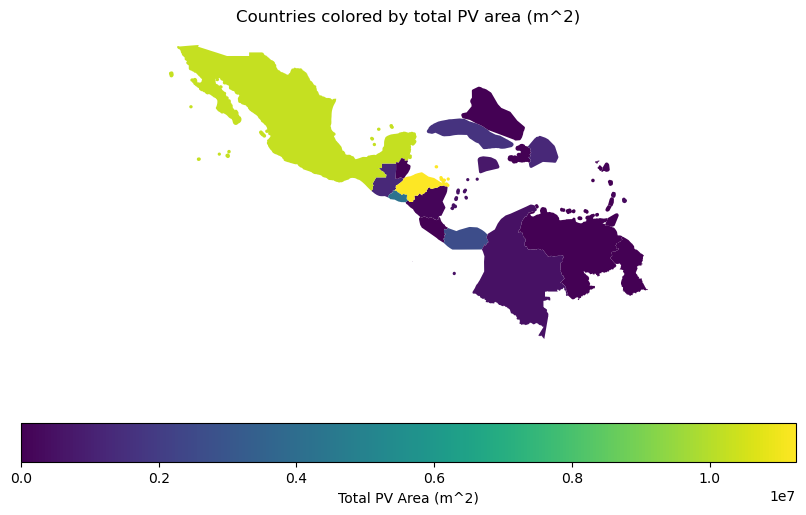

In [50]:
# generate a simple chloropleth map of the countries in the selected region
# generate a simple chloropleth map of the countries in the selected region
# Common cmap options include: 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 
# 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 
# 'YlOrBr', 'YlOrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
# Diverging: 'coolwarm', 'bwr', 'seismic'
# Qualitative: 'tab10', 'tab20', 'Paired', 'Set1', 'Set2', 'Set3'
print(region_dropdown.value)
# TODO: fix region update
bbox = region_bboxes[region_dropdown.value]
countries_in_region = conn.execute(f"""
    SELECT DISTINCT country_iso
    FROM country_geoms
    WHERE ST_Intersects(geometry, ST_MakeEnvelope({bbox['xmin']}, {bbox['ymin']}, {bbox['xmax']}, {bbox['ymax']}));""").fetchall()
countries_in_region = [row[0] for row in countries_in_region]
print(countries_in_region)
countries_gdf = get_countries_gdf(countries_in_region)
countries_gdf.plot(column="country_pv_area_m2", cmap='viridis', legend=True, legend_kwds={'label': "Total PV Area (m^2)", 'orientation': "horizontal"}, figsize=(10, 6))
plt.title("Countries colored by total PV area (m^2)")
# remove axes
plt.axis('off')
plt.show()

In [45]:
# interactive plot to use geopandas' plot function
country_name_to_iso = get_countries_in_bbox(region_bboxes[region_dropdown.value])
random_default = random.choice(list(country_name_to_iso.keys()))
country_select = widgets.Dropdown(
    options=list(country_name_to_iso.keys()),
    description='Country:',
    value=random_default,
    disabled=False,
    layout=Layout(width='70%', margin='20 20 auto 20 20')
)

# temporarily 

# TODO: add region geoms so plot is meaningful
@interact(country_name=country_select)
def plot_country(country_name):
    # Get the ISO code for the selected country
    iso_code = country_name_to_iso[country_name]
    
    # Filter the GeoDataFrame for the selected country
    filtered_gdf = get_countries_gdf([iso_code])
    
    # Plot the filtered GeoDataFrame
    fig, ax = plt.subplots(figsize=(8, 12))
    ax.set_title(f"Countries colored by count of PV labels")
    ax.set_axis_off()
    filtered_gdf.plot(column="country_pv_count", ax=ax, legend=True, cmap='OrRd')
    plt.show()

interactive(children=(Dropdown(description='Country:', index=26, layout=Layout(margin='20 20 auto 20 20', widt…

## Lonboard Visualization Functions

Lonboard is a GPU-accelerated geospatial visualization library that's excellent for handling very large datasets. It's particularly useful for creating high-performance interactive visualizations of millions of data points.

In [46]:
# %config SqlMagic.autopandas = True

# 1. Get ISO codes
# Countries for filtering
country_isos = get_countries_in_bbox(region_bboxes[region_dropdown.value])
div_countries = list(country_isos.keys())

# valid data for H3ClusterLayer

# --- Database Connection and Query ---
# db_path = str(out_consolidated_db) # Use db path from CELL 24/49
pv_table_name = TABLE_NAME
h3_col = f"h3_res_{common_h3_res}"
 

# h3_agg_df = pd.DataFrame(columns=[h3_col, 'region' 'pv_count', 'total_area_m2', 'hex_ids'])

view_lat, view_lon = 48.0, 9.0  # Default center (Central Europe)
    
# Create country selection dropdown
country_dropdown = widgets.Dropdown(
    options=div_countries,
    value=div_countries[0] if div_countries else None,
    description='Country:',
    disabled=False
)

def get_country_hex_cells(gdf, country_iso, h3_col):
    # aggregate our pv labels by h3_col and filter to country selected in dropdown
    h3_agg_query = f"""
    SELECT 
        h3_h3_to_string({h3_col}) as hex, division_region as region,
        COUNT(*) AS pv_count, SUM(area_m2) AS total_area_m2
    FROM {TABLE_NAME}
    -- only aggregate one type of division to avoid double counting pv labels that match with multiple divisions (almost all)
    WHERE division_country = '{country_isos[country_dropdown.value]}' and division_subtype = 'region'
    GROUP BY {h3_col}, division_region
    -- HAVING COUNT(*) > 0
    """
    # conn.install_extension("h3", "community")
    # conn.load_extension("h3")
    results = conn.execute(h3_agg_query).fetchall()
    # convert to DataFrame
    gdf = pd.DataFrame(results, columns=gdf.columns)
    # make sure hex is a string
    gdf['hex'] = gdf['hex'].astype(str)
    print(gdf['hex'].head())
    # gdf = gpd.GeoDataFrame(
    #     gdf,
    #     geometry=gpd.GeoSeries.from_wkt(gdf['hex'].apply(h3.cell_to_boundary)),
    #     crs="EPSG:4326"
    # )

    return gdf

In [47]:
# %% Helper Functions

def get_country_iso_codes() -> dict:
    """Gets ISO 3166-1 alpha-2 codes for a list of country names."""
    # (Function remains the same as before)
    # Countries for filtering; only include countries that are in our PV labels
    div_countries = conn.execute(f"""SELECT DISTINCT division_country FROM country_geoms;""").fetchall()
    div_country_isos = [row[0] for row in div_countries]
    div_countries = []
    for iso in div_country_isos:
        try:
            country = pycountry.countries.get(alpha_2=iso)
            if country:
                div_countries.append(country.name)
            else:
                div_countries.append(iso)
        except:
            div_countries.append(iso)

    div_countries = [pycountry.countries.get(alpha_2=iso).name for iso in div_countries]
    country_name_to_iso = dict(zip(div_countries, div_country_isos))

    return country_name_to_iso

def get_country_centroid(country_iso: str, db_conn: duckdb.DuckDBPyConnection) -> tuple | None:
    """Fetches the centroid coordinates for a given country ISO code."""
    # (Function remains the same as before)
    if not db_conn: return None
    try:
        centroid_query = f"""
        SELECT ST_Y(country_centroid) AS country_lat, ST_X(country_centroid) AS country_lon
        FROM (
            SELECT ST_Centroid(ST_MakeEnvelope(div_bbox.xmin, div_bbox.ymin, div_bbox.xmax, div_bbox.ymax)) AS country_centroid
            FROM {pv_table_name} WHERE division_country = ? AND division_subtype = 'country' LIMIT 1
        ) AS subquery;
        """
        result = db_conn.execute(centroid_query, [country_iso]).fetchone()
        return (result[0], result[1]) if result else (48.0, 9.0)
    except Exception as e:
        print(f"Error fetching centroid for {country_iso}: {e}")
        return (48.0, 9.0)

def get_country_geometry(country_iso: str, db_conn: duckdb.DuckDBPyConnection) -> Polygon | None:
    """Fetches the primary administrative boundary geometry for a country."""
    if not db_conn:
        print("Database connection is not available for geometry fetch.")
        return None
    try:
        # Fetch all divisions for the country
        geom_query = f"""
        SELECT ST_AsWKB(geometry)
        FROM {ov_divisions_table}
        where country = '{country_iso}' and subtype = 'country';
        """
        result = db_conn.execute(geom_query).fetchone()
        if result and result[0]:
            # Convert WKB back to Shapely geometry
            from shapely import wkb
            country_geom = wkb.loads(result[0])
            print(f"Fetched geometry for {country_iso} (Type: {country_geom.geom_type})")
            return country_geom
        else:
            print(f"Warning: Could not find geometry for country ISO: {country_iso}")
            return None
    except Exception as e:
        print(f"Error fetching geometry for {country_iso}: {e}")
        return None

def safe_h3_to_polygon(h3_index: str) -> Polygon | None:
    """Safely converts an H3 index string to a Shapely Polygon."""
    # (Function remains the same as before)
    try:
        boundary_lon_lat = h3.cell_to_boundary(h3_index, geo_json=True)
        return Polygon(boundary_lon_lat)
    except ValueError: return None
    except Exception: return None

In [57]:
def get_country_hex_data_as_gdf(country_iso: str, target_h3_res: int, db_conn: duckdb.DuckDBPyConnection) -> gpd.GeoDataFrame:
    """
    Gets all H3 cells within a country's boundary using h3.polyfill and __geo_interface__,
    joins PV aggregation data, adds geometry using h3pandas,
    and returns a GeoDataFrame.
    """
    if not db_conn:
        print("Database connection is not available.")
        return gpd.GeoDataFrame()

    # 1. Get Country Geometry
    country_geom = get_country_geometry(country_iso, db_conn)
    print(f"Country geometry for {country_iso}: {country_geom}")
    if not country_geom:
        return gpd.GeoDataFrame()

    # 2. Get all H3 cells covering the geometry using h3.polyfill and __geo_interface__
    try:
        # Get the GeoJSON-like dictionary from the Shapely object
        country_geojson_interface = country_geom.__geo_interface__
        print(country_geojson_interface)
        h3shape = h3.geo_to_h3shape(country_geojson_interface)
        # h3shape = h3.geo_to_h3shape(country_geom)
        print(f"Filling geometry with H3 cells using h3.polyfill at resolution {target_h3_res}...")
        # Use geo_json_conformant=True because __geo_interface__ uses [lon, lat] order
        all_cells_set = h3.h3shape_to_cells(h3shape, target_h3_res)
        print(f"Found {len(all_cells_set)} H3 cells covering {country_iso}.")
        print(all_cells_set)
        if not all_cells_set:
             print(f"Warning: h3.polyfill returned no cells for {country_iso}.")
             return gpd.GeoDataFrame()
        all_cells_list = list(all_cells_set) # Convert set to list
        print(f"Found {len(all_cells_list)} H3 cells covering {country_iso}.")
    except Exception as e:
        print(f"Error during h3.polyfill for {country_iso}: {e}")
        return gpd.GeoDataFrame()

    # 3. Create DataFrame of all H3 cells and set H3 index for h3pandas
    all_country_cells_df = pd.DataFrame({'hex_id': all_cells_list}).set_index('hex_id')

    # 4. Aggregate PV data for these cells from DuckDB
    h3_col_in_pv_table = f"h3_res_{h3_resolution}" # Use the global resolution variable
    # Create a list of values string for the SQL query (e.g., "('id1'), ('id2'), ...")
    values_list_str = ', '.join([f'(\'{cell}\')' for cell in all_cells_list])
    if not values_list_str: # Handle case where polyfill returns empty list
        print("No relevant cells found to query PV data.")
        pv_agg_df = pd.DataFrame(columns=['hex', 'pv_count', 'total_area_m2'])
    else:
        h3_agg_query = f"""
        WITH RelevantCells AS (
            SELECT column0 AS hex_id FROM (VALUES {values_list_str})
        )
        SELECT
            h3_h3_to_string({h3_col_in_pv_table}) as hex,
            COUNT(*) AS pv_count,
            SUM(area_m2) AS total_area_m2
        FROM {pv_table_name}
        INNER JOIN RelevantCells ON h3_h3_to_string({h3_col_in_pv_table}) = RelevantCells.hex_id
        WHERE division_country = ?
        GROUP BY hex;
        """
        try:
            print(f"Aggregating PV data for relevant cells in {country_iso}...")
            pv_agg_df = db_conn.execute(h3_agg_query, [country_iso]).fetchdf()
            print(f"Found PV data for {len(pv_agg_df)} cells.")
        except Exception as e:
            print(f"Error aggregating PV data: {e}")
            pv_agg_df = pd.DataFrame(columns=['hex', 'pv_count', 'total_area_m2'])

    # 5. Use h3pandas to add geometry boundary to the DataFrame of all cells
    print("Generating hexagon geometries using h3pandas...")
    try:
        gdf_all_cells = all_country_cells_df.h3.h3_to_geo_boundary()
        gdf_all_cells = gdf_all_cells.reset_index().rename(columns={'hex_id': 'hex'})
        print(f"Generated geometries for {len(gdf_all_cells)} cells.")
    except Exception as e:
        print(f"Error using h3pandas to generate geometries: {e}")
        return gpd.GeoDataFrame()

    # 6. Left join the GeoDataFrame with aggregated PV data
    print("Joining all country cells (with geometry) with PV aggregates...")
    if not pv_agg_df.empty:
        pv_agg_df['hex'] = pv_agg_df['hex'].astype(str)
    merged_gdf = pd.merge(gdf_all_cells, pv_agg_df, on='hex', how='left')

    # 7. Fill NaNs and set CRS
    merged_gdf['pv_count'] = merged_gdf['pv_count'].fillna(0).astype(int)
    merged_gdf['total_area_m2'] = merged_gdf['total_area_m2'].fillna(0).astype(float)
    merged_gdf.crs = 'EPSG:4326'
    print(f"Created final GeoDataFrame with {len(merged_gdf)} polygons for {country_iso}.")
    return merged_gdf

In [58]:
# %% Visualization Function (Lonboard)

def create_lonboard_viz(gdf: gpd.GeoDataFrame, view_lat: float, view_lon: float) -> lonboard.Map | None:
    """Creates the Lonboard PolygonLayer visualization."""
    # (Function remains the same as the last working version)
    if gdf.empty:
        print("No data to visualize.")
        return None
    try:
        pv_counts_numeric = pd.to_numeric(gdf['pv_count'], errors='coerce').fillna(0)
        values_array = pv_counts_numeric.to_numpy(dtype=float)
        fill_colors_rgba = lonboard.colormap.apply_continuous_cmap(
            values_array, cmap=cm.viridis, alpha=0.75
        )
        polygon_layer = lonboard.PolygonLayer.from_geopandas(
            gdf,
            get_fill_color=fill_colors_rgba,
            get_line_color=[255, 255, 255, 80],
            line_width_min_pixels=0.5,
            pickable=True,
            auto_highlight=True,
        )
        view_state_params = {"latitude": view_lat, "longitude": view_lon, "zoom": 6, "pitch": 30, "bearing": 0}
        m = lonboard.Map(layers=[polygon_layer], view_state=view_state_params)
        return m
    except ImportError:
        print("Error: Required libraries not found.")
        return None
    except Exception as e:
        print(f"Error creating lonboard visualization: {e}")
        raise e # Re-raise to see full traceback

# %% Main Execution Logic (with Widgets)

# 1. Get map from Country Name -> ISO code
bbox = country_select.value
country_name_iso_map = get_countries_in_bbox(region_bboxes[region_dropdown.value])
#  filter to countries that have pv_count > 0
countries_with_pv = conn.execute(f"""SELECT DISTINCT division_country FROM {TABLE_NAME} WHERE unified_id is not null;""").fetchall()
countries_with_pv = set([row[0] for row in countries_with_pv if row[0] is not None])
print(f"Countries with PV labels: {countries_with_pv}")
print(country_name_iso_map)
valid_countries = {k: v for k, v in country_name_iso_map.items() if v in countries_with_pv}
print(f"Valid countries with PV labels: {valid_countries}")
# region_countries = sorted(list(country_name_iso_map.keys()))
valid_countries = sorted(list(valid_countries.keys())) # Sort for usability

# 2. Create Widgets
country_dropdown = widgets.Dropdown(
    options=valid_countries,
    value=valid_countries[0] if valid_countries else None,
    description='Country:',
    disabled=False if valid_countries else True,
    layout=widgets.Layout(width='300px')
)

# Output widget to display the map
map_output = widgets.Output()

# 3. Define Update Function for Visualization
def update_visualization(selected_country):
    """Fetches data and updates the map in the output widget."""
    with map_output:
        clear_output(wait=True)
        print(f"--- Updating map for: {selected_country} ---")
        conn = get_duckdb_connection(db_file)
        if 'conn' not in locals() or conn is None:
             print("Database connection error. Cannot update map.")
             return

        country_iso = country_name_iso_map.get(selected_country) # Use the map
        print(f"Selected country ISO: {country_iso}")
        if not country_iso:
            print(f"ISO code not found for {selected_country}.")
            return

        # Fetch aggregated hex data AS GeoDataFrame using the new logic
        country_hex_gdf = get_country_hex_data_as_gdf(country_iso, h3_col, conn)
        print(f"Fetched {len(country_hex_gdf)} hex cells for {selected_country}.")

        # Fetch centroid
        center_lat, center_lon = get_country_centroid(country_iso, conn)

        if center_lat is None or center_lon is None:
            print("Could not determine map center.")
            return

        print(f"Map centered on {selected_country}: Lat={center_lat:.4f}, Lon={center_lon:.4f}")

        # Create and display the Lonboard visualization
        lonboard_map = create_lonboard_viz(country_hex_gdf, center_lat, center_lon)

        if lonboard_map:
            print(f"Displaying Lonboard map for {selected_country}...")
            display(lonboard_map)
        else:
            print(f"No visualization generated for {selected_country}.")
        print(f"--- Finished update for: {selected_country} ---")

# 4. Link Dropdown to Update Function using interactive_output
widgets.interactive_output(update_visualization, {'selected_country': country_dropdown})

# 5. Display Widgets
print("Select a country from the dropdown to visualize its H3 grid using Lonboard.")
display(country_dropdown, map_output)
# Trigger initial display for the default country if available
if country_dropdown.value:
    update_visualization(country_dropdown.value)

Countries with PV labels: {'RO', 'EE', 'FI', 'CY', 'PH', 'SV', 'EC', 'OM', 'NA', 'RS', 'BF', 'GG', 'VU', 'AL', 'UA', 'PT', 'UY', 'QA', 'VI', 'KN', 'BH', 'BB', 'ML', 'IN', 'AR', 'LC', 'IL', 'CN', 'NI', 'TO', 'NC', 'CV', 'PL', 'UZ', 'BG', 'GF', 'PR', 'BI', 'SI', 'BY', 'AF', 'TN', 'XK', 'SS', 'AU', 'MM', 'MQ', 'NG', 'JM', 'LI', 'BD', 'SH', 'CM', 'ER', 'KZ', 'MU', 'AT', 'AE', 'RW', 'GR', 'LT', 'PE', 'BE', 'AS', 'SK', 'GN', 'TR', 'US', 'DK', 'RU', 'DZ', 'HN', 'GT', 'JP', 'TD', 'AW', 'NL', 'GU', 'IR', 'LR', 'HR', 'ES', 'CR', 'TH', 'SY', 'UG', 'KP', 'PF', 'DE', 'JO', 'MY', 'DO', 'CZ', 'AM', 'ID', 'UM', 'GM', 'YT', 'RE', 'LS', 'MN', 'IE', 'BO', 'ZA', 'HK', 'LK', 'CA', 'ZW', 'GE', 'MK', 'BN', 'AG', 'AZ', 'SM', 'BA', 'HU', 'SN', 'LU', 'IT', 'SE', 'NZ', 'EG', 'CH', 'FR', 'TG', 'MR', 'BJ', 'CU', 'CO', 'PA', 'GB', 'GP', 'GH', 'LA', 'NO', 'MX', 'CL', 'TW', 'HT', 'WS', 'NP', 'KH', 'KR'}
{'Antigua and Barbuda': 'AG', 'Anguilla': 'AI', 'Aruba': 'AW', 'Barbados': 'BB', 'Saint Barthélemy': 'BL', 'Bonaire

Dropdown(description='Country:', layout=Layout(width='300px'), options=('Antigua and Barbuda', 'Aruba', 'Barba…

Output()

In [ ]:
geom_query = f"""
    SELECT ST_AsWKB(geometry)
    FROM {ov_divisions_table}
    where country = '{country_dropdown.value}' and subtype = 'country';
    """
result = conn.execute(geom_query).fetchone()
print(f"Result: {result}")

Result: None


### [Optional] Drop Overture Maps Divisions 

Now that we have the metadata for the Overture Maps Divisions that matches our PV labels, we can drop the 
large (~6.4GB without filtering by country or subtype) Divisions table from our DuckDB database and simply query the Overture Maps S3 bucket for the relevant division geometries when needed.

In [ ]:
from IPython.display import display, clear_output

# display large widget text and large warning button in a layout 
# Create a warning message with HTML widget
warning_text = widgets.HTML(
    value="""
    <div style="color: #d9534f; font-size: 1.5em; font-weight: bold; text-align: center; 
               padding: 20px; border: 2px solid #d9534f; border-radius: 10px; background-color: #f9f2f4;">
    ⚠️ WARNING: This will permanently delete the Overture Maps Divisions table (~6.4GB) from the database and will need to be re-downloaded.<br>
    Only do this if you're SURE you no longer need direct access to the division geometries.
    </div>
    """,
    layout=widgets.Layout(margin="10px 0px 20px 0px")
)

# Create a drop table button with warning styling
drop_button = widgets.Button(
    description="DROP Overture Divisions Table",
    button_style="danger",
    icon="trash",
    layout=widgets.Layout(width="80%", height="60px", margin="0 auto", 
                          font_weight="bold", font_size="1.2em")
)

# Function to drop the table
def drop_divisions_table(b):
    
    # Create output area to show results
    output = widgets.Output()
    display(output)
    
    with output:
        clear_output(wait=True)
        print(f"Dropping table {ov_divisions_table}...")
        try:
            # Use SQL magic to drop the table
            %sql DROP TABLE IF EXISTS {{ov_divisions_table}};
            print(f"✅ Table {ov_divisions_table} successfully dropped!")
        except Exception as e:
            print(f"❌ Error dropping table: {e}")

# Connect the function to the button click event
drop_button.on_click(drop_divisions_table)

# Create the final layout
widgets.VBox([warning_text, drop_button], 
            layout=widgets.Layout(width="70%", margin="0 auto", padding="20px", 
                                 border="1px solid #d9534f", border_radius="10px"))

In [ ]:
stac_items = fetch_cubo_stac_rasters_samples(ds_gdf_h3, visualize_set=True, sample_size=5)
stac_items

NameError: name 'fetch_cubo_stac_rasters_samples' is not defined

In [ ]:
# visualize one of the samples
np.random.seed(42)
# print(pv_da)
# pv_da = samples.isel(time=0)
pv_uniq = stac_items.groupby('time').first()
(pv_uniq.sel(band=["B04","B03","B02"])/5000).clip(0,1).plot.imshow(col="time",col_wrap = 3)

In [ ]:
# def create_temporal_animation(stacked_data, output_path="pv_animation.gif"):
#     """Create an animated GIF showing temporal changes"""
#     import matplotlib.pyplot as plt
#     import matplotlib.animation as animation
    
#     # Prepare RGB data
#     rgb_data = []
#     for t in stacked_data.time.values:
#         # rgb = visualize_enhanced_rgb(stacked_data.sel(time=t))
#         rgb_data.append(rgb.transpose("y", "x", "band").values)
    
#     # Create animation
#     fig, ax = plt.figure(figsize=(10, 10)), plt.gca()
    
#     # Create initial image
#     im = ax.imshow(rgb_data[0])
#     ax.set_axis_off()
    
#     # Define update function for animation
#     def update(frame):
#         im.set_array(rgb_data[frame])
#         ax.set_title(f"Date: {stacked_data.time.values[frame]}")
#         return [im]
    
#     # Create and save animation
#     ani = animation.FuncAnimation(fig, update, frames=len(rgb_data), interval=500)
#     ani.save(output_path, writer='pillow')
    
#     return ani

In [ ]:
# create_temporal_animation(stac_items[0], output_path="pv_animation.gif")

In [ ]:
# import pystac_client
# import pystac
# import geopandas as gpd
# from shapely.geometry import box
# import matplotlib.pyplot as plt
# import warnings

# # Suppress specific UserWarning from pystac_client about ItemSearch link
# warnings.filterwarnings("ignore", message="Server does not conform to ITEM_SEARCH.*", category=UserWarning)

# # --- Configuration ---
# MAXAR_OPEN_DATA_CATALOG_URL = "https://maxar-opendata.s3.amazonaws.com/events/catalog.json"

# # --- STAC Traversal ---
# print(f"Connecting to catalog: {MAXAR_OPEN_DATA_CATALOG_URL}...")
# all_items = []
# try:
#     # Open the root STAC Catalog
#     root_catalog = pystac_client.Client.open(MAXAR_OPEN_DATA_CATALOG_URL)
#     print("Successfully connected to root catalog.")

#     # Get top-level children (likely Collections or Catalogs representing events)
#     print("Fetching top-level children (Events)...")
#     top_children = list(root_catalog.get_children())
#     print(f"Found {len(top_children)} top-level children (Events).")

#     # Iterate through the top-level children (Events)
#     for event_child in top_children:
#         print(f"\nProcessing Event Child: {event_child.id} ({type(event_child)})...")
#         try:
#             # Attempt to get items directly from this event child
#             # get_items() should work for both Catalog and Collection objects if they contain items
#             print(f"  Fetching items from {event_child.id}...")
#             # Resolve the child first if it's just a link (get_children often returns resolved)
#             # event_child.resolve_stac_object() # Might be needed if get_children returns unresolved links

#             items_in_event = list(event_child.get_items(recursive=False)) # Use recursive=True just in case
#             if items_in_event:
#                  print(f"    Found {len(items_in_event)} items directly in {event_child.id}.")
#                  all_items.extend(items_in_event)
#           #   else:
#           #        # If no items directly, check if it has children itself (deeper nesting)
#           #        print(f"    No items found directly in {event_child.id}. Checking for sub-children...")
#           #        try:
#           #             sub_children = list(event_child.get_children())
#           #             if sub_children:
#           #                  print(f"    Found {len(sub_children)} sub-children in {event_child.id}.")
#           #                  for sub_child in sub_children:
#           #                       print(f"      Fetching items from sub-child: {sub_child.id}...")
#           #                       try:
#           #                            items_in_sub = list(sub_child.get_items(recursive=True))
#           #                            print(f"        Found {len(items_in_sub)} items in {sub_child.id}.")
#           #                            all_items.extend(items_in_sub)
#           #                       except Exception as sub_item_err:
#           #                            print(f"        Error fetching items from {sub_child.id}: {sub_item_err}")
#           #             else:
#           #                  print(f"    No sub-children found in {event_child.id}.")
#           #        except Exception as sub_child_err:
#           #             print(f"    Error fetching sub-children for {event_child.id}: {sub_child_err}")

#         except AttributeError as ae:
#              # Handle cases where an object might not have get_items or get_children
#              print(f"  Skipping {event_child.id}, does not appear to be a Catalog/Collection or error occurred: {ae}")
#         except Exception as event_err:
#             print(f"  Error processing {event_child.id}: {event_err}")


#     print(f"\nTotal items fetched from all events: {len(all_items)}")

#     # --- Data Extraction and Preparation --- (Same as before)
#     if not all_items:
#         print("No items found after traversing. Exiting.")
#     else:
#         print("Extracting bounding boxes...")
#         bboxes = []
#         item_ids = []
#         for item in all_items:
#             if item.bbox:
#                 bboxes.append(item.bbox)
#                 item_ids.append(item.id)
#             else:
#                 # It's also possible geometry exists but not bbox
#                 if item.geometry:
#                      try:
#                           # Calculate bbox from geometry (more expensive)
#                           min_lon, min_lat, max_lon, max_lat = gpd.GeoSeries([item.geometry], crs="EPSG:4326").total_bounds
#                           bboxes.append([min_lon, min_lat, max_lon, max_lat])
#                           item_ids.append(item.id)
#                           print(f"Info: Item {item.id} using geometry bounds.")
#                      except Exception as geom_err:
#                           print(f"Warning: Item {item.id} has no bbox and failed to get bounds from geometry: {geom_err}")
#                 else:
#                      print(f"Warning: Item {item.id} has no bbox or geometry.")


#         if not bboxes:
#              print("No items with bounding boxes found. Cannot plot.")
#         else:
#             # Convert bounding boxes (min_lon, min_lat, max_lon, max_lat) to Shapely polygons
#             geometries = [box(min_lon, min_lat, max_lon, max_lat) for min_lon, min_lat, max_lon, max_lat in bboxes]

#             # Create a GeoDataFrame
#             gdf_items = gpd.GeoDataFrame({'id': item_ids, 'geometry': geometries}, crs="EPSG:4326")
#             print(f"Created GeoDataFrame with {len(gdf_items)} item extents.")
#             print(gdf_items.head()) # Display first few rows

#             # --- Plotting --- (Same as before)
#             print("Plotting item extents...")
#             world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#             fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#             world.plot(ax=ax, color='lightgray', edgecolor='black')
#             gdf_items.plot(ax=ax, color='red', alpha=0.5, edgecolor='red', linewidth=0.5) # Adjusted linewidth
#             ax.set_title(f'Maxar Open Data Catalog Item Extents ({len(gdf_items)} items)')
#             ax.set_xlabel('Longitude')
#             ax.set_ylabel('Latitude')
#             # Consider setting limits based on data extent if it's geographically concentrated
#             minx, miny, maxx, maxy = gdf_items.total_bounds
#             ax.set_xlim(minx - 2, maxx + 2) # Add padding
#             ax.set_ylim(miny - 2, maxy + 2)
#             plt.tight_layout() # Adjust layout
#             plt.show()
#             print("Plotting complete.")

# except Exception as e:
#     print(f"An error occurred during catalog processing: {e}")

In [ ]:
# from maxar_platform.session import session
# session.login()

In [ ]:
# # --- Pydeck Visualization ---
# country_gdf = pd.DataFrame(columns=['hex', 'region', 'pv_count', 'total_area_m2'])
# selected_country = country_dropdown.value
# country_iso = country_isos[selected_country]
# country_gdf = get_country_hex_cells(country_gdf, country_iso, h3_col)
# print(f"Aggregated {len(country_gdf)} H3 cells for {selected_country}.")
# # check df column data types
# print(country_gdf.dtypes)
# country_center = conn.execute(f"""SELECT ST_X(country_centroid) AS country_lon, ST_Y(country_centroid) AS country_lat
#     FROM (SELECT ST_Centroid(ST_MakeEnvelope(div_bbox.xmin, div_bbox.ymin, div_bbox.xmax, div_bbox.ymax)) AS country_centroid 
#     FROM {TABLE_NAME}
#     WHERE division_country = '{country_iso}' and division_subtype = 'country'
#     LIMIT 1) AS subquery
#     """).fetchone()
# # Calculate the center point from our data
# view_lat = country_center[1]
# view_lon = country_center[0]
# print(f"Map centered on {selected_country}: Lat={view_lat:.4f}, Lon={view_lon:.4f}")

# # print(country_gdf)

# if not country_gdf.empty:
    
#     # Function to update map based on country selection
#     # def update_map(change):
#     #     if change['type'] == 'change' and change['name'] == 'value':
#     #         selected_country = change['new']

#     #         try:
#     #             global country_gdf
#     #             # Get ISO code for selected country
#     #             country_iso = country_isos[selected_country]
#     #             country_gdf = get_country_hex_cells(country_gdf, country_iso, h3_col)

#     #             if not country_gdf.empty:
#     #                 country_center = conn.execute(f"""SELECT ST_X(country_centroid) AS country_lon, ST_Y(country_centroid) AS country_lat
#     #                 FROM (SELECT ST_Centroid(CAST(division_bbox AS Box_2D)) AS country_centroid FROM {TABLE_NAME})
#     #                 WHERE division_country = '{country_isos[country_dropdown.value]}' and division_subtype = 'country'
#     #                 """).fetchone()[0]
#     #                 # Calculate the center point from our data
#     #                 view_lat = country_center[1]
#     #                 view_lon = country_center[0]
#     #                 print(f"Map centered on {selected_country}: Lat={view_lat:.4f}, Lon={view_lon:.4f}")
                
#     #             print(f"Map centered on {selected_country}: Lat={view_lat:.4f}, Lon={view_lon:.4f}")
#     #             # print(f"Aggregated {len(country_gdf)} H3 cells for {selected_country}.")
#     #             # conn.close()
                
#     #             # The map will be updated when the cell is re-run
#     #             # For automatic updates, we would need to integrate with a framework like ipywidgets interactions
                
#     #         except Exception as e:
#     #             print(f"Error updating map for {selected_country}: {e}")
    
#     # Register callback
#     # country_dropdown.observe(update_map)

#     # 4. Create Pydeck Layer
#     # Simple color scale: more PV installations -> more red
#     # Adjust divisor (pv_count + 10) based on typical counts for better color spread
#     color_expression = "[255, (1 - pv_count / (pv_count + 50)) * 255, 200]" # RGBA (Added alpha)
#     # data format for H3HexagonLayer is [{h3_index_col: <cell_hex>, "attr1": <value1>, "attr2": <value2>, ...}, ...]
#     # Convert Dataframe to list of dictionaries

#     h3_cells = country_gdf.to_dict(orient='records')
#     # print(h3_cells)
#     # display(country_gdf.sample(5))


#     h3_layer = pdk.Layer(
#         "H3HexagonLayer",
#         # data=country_gdf,
#         data=h3_cells,
#         pickable=True,
#         stroked=True, # Show hexagon outlines
#         filled=True,
#         extruded=True, # Start flat, can be toggled
#         get_hexagon="hex", # H3 index column
#         get_fill_color=color_expression,
#         get_line_color=[255, 255, 255, 100], # White outline with some transparency
#         line_width_min_pixels=2,
#         # Elevation can be based on count or area if extruded=True
#         get_elevation="total_area_m2",
#         elevation_scale=1.8, # Needs tuning if extruded
#         get_weight="pv_count", # Used by the layer for internal calculations
#         auto_highlight=True,
#     )
#     # print(f"Created H3HexagonLayer: {h3_layer}")

#     # 5. Define Initial View State
#     view_state = pdk.ViewState(
#         latitude=view_lat,
#         longitude=view_lon,
#         zoom=5, # Adjust zoom level for selected countries
#         pitch=40.5,
#         bearing=-27.36
#     )

#     # pv_points = gpd.GeoDataFrame(columns=['lng', 'lat'])
#     # pv_points['lng'] = ds_gdf_h3['geometry'].apply(lambda x: x.centroid.x)
#     # pv_points['lat'] = ds_gdf_h3['geometry'].apply(lambda x: x.centroid.y)
#     # print(pv_points.sample(5))

#     # layer = pdk.Layer(
#     #     "HexagonLayer",
#     #     ,
#     #     get_position=["lng", "lat"],
#     #     auto_highlight=True,
#     #     elevation_scale=50,
#     #     pickable=True,
#     #     elevation_range=[0, 3000],
#     #     extruded=True,
#     #     coverage=1,
#     # )

#     # 6. Define Tooltip
#     tooltip = {
#         "text": "Region: {region}\nPV Count: {pv_count}\nTotal Area (m²): {total_area_m2}"
#     }

#     # --- Interactivity (Optional: Toggle Extrusion) ---
#     extruded_checkbox = widgets.Checkbox(value=False, description='Extrude by Total Area')

#     # Function to update the layer's extruded property
#     def update_extrusion(change):
#         h3_layer.extruded = change['new']
#         # Note: This requires re-rendering the deck or using a mechanism
#         # that updates the layer state if pydeck supports it directly via traitlets.
#         # For simplicity here, we'll just show how to set it initially or via a button.
#         # A full interactive update might need deck.update() or similar if available,
#         # or embedding in a framework like Voila/Streamlit.
#         print(f"Extrusion set to: {h3_layer.extruded}") # Shows change, but won't auto-update displayed map

#     # extruded_checkbox.observe(update_extrusion, names='value')
#     # Display the checkbox (won't dynamically update the map below in standard Jupyter)
#     # display(extruded_checkbox)


#     # 7. Create and Display Pydeck Deck
#     print("Rendering Pydeck map...")
#     deck = pdk.Deck(
#         layers=[h3_layer],
#         initial_view_state=view_state,
#         map_style='dark', # Options: 'light', 'dark', 'satellite', 'road'
#         tooltip=tooltip,
#     )
#     # deck = pdk.Deck([h3_layer])
#     display(deck) # Display the map in Jupyter

# else:
#     print("No aggregated H3 data available to visualize for the selected countries.")